In [1]:
%load_ext jupyter_black

# Capstone Sprint 3
* Due Date: September 5, 2023
* Author: Vivasvat Kaul

## Table of Contents: <a class="anchor" id="toc"></a>
1. [Introduction](#1)
2. [Load Packages](#2)
3. [Setting Environment Variables](#3)
4. [Data Acquisition](#4)
    1. [MP3 Downloader](#4_1)
5. [Exploratory Data Analysis](#5)
    1. [Kaggle Dataset Exploration](#5_1)
    2. [Librosa Spectrograms](#5_2)
        1. [Mel Spectrogram](#5_2_1)
        2. [Mel Frequency Cepstral Coefficients (MFCC)](#5_2_2)
        3. [Chroma Vector](#5_2_3)
        4. [Tonal Centroid Features (Tonnetz) Spectrum](#5_2_4)
6. [CNN Model Setup](#6)
    1. [CNN Image Visualization](#6_1) 
8. [Vectorizing Data](#7)
    1. [Count MP3s](#7_1)
    2. [Generate Track Feature Files](#7_2)
        1. [Normal Pairwise and CNN Matrices](#7_2_1)
        2. [Create Complete Pairwise Parquet](#7_2_2)
        3. [Create Complete CNN Parquet](#7_2_3)
9. [Pairwise Cosine Similarity](#8)
    1. [Normal Parquet](#8_1)
    2. [CNN Parquet](#8_2)
    3. [Compute Similarity](#8_3)
        1. [Normal Similarity](#8_3_1)
        2. [CNN Similarity](#8_3_2)
        3. [Check Normal Recommendations](#8_3_3)
        4. [Check Normal Dissimilar](#8_3_4)
        5. [Check CNN Recommendations](#8_3_5)
        6. [Check CNN Dissimilar](#8_3_6)
        7. [Comparison of Mean Similarities ](#8_3_7)
10. [Creating Recommendation Playlist](#9)
    1. [Flask App for Authorization](#9_1)
    2. [Playlist Creation](#9_2)
11. [Conclusion](#10)

## 1. Introduction <a class="anchor" id="1"></a>

The objective for Sprint 3 was to finalize this project and focus on the refinement of the model and its evalutation. Additionally, ideas from Sprints 0, 1, and 2 are further refined here. Finally, steps were taken to prepare this code for showcasing on Demo Day. This notebook contains all of the relevant code for this project starting with the acquisition of the mp3 data and an exploration of the Kaggle dataset that helped obtain it, all the way to to a comparison of the two models and the playlists generated from both. Outputs relevant to the project have also been added to the repo along with outputs that act as backups to help with project reproducibility.

[Back to Table of Contents](#toc)

## 2. Load Packages <a class="anchor" id="2"></a>

Packages relavant to th code are loaded below. Additionally, specific options or parameters are also set. For example, display options are set for `pandas` and the environment path to the environment variable file is provided for the `dotenv` package. Additionally, a magic command `load_ext` was added to bring in the `jupyter-black` package to help format code to be more readable.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os
import sys
import pandas as pd
import numpy as np
import requests
from spotify_dl import spotify_dl
from pathlib import Path
import time
import os
from dotenv import load_dotenv  # changed magic command to explicit load
import librosa
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import pairwise
from sklearn.model_selection import train_test_split
from typing import List
from flask import Flask, redirect, request
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

# from tensorflow.keras.layers import Conv2D  # new
# from tensorflow.keras.layers import MaxPooling2D  # new
from tensorflow.keras.layers import Flatten  # new

# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping
from skimage.transform import resize


pd.set_option("display.max_rows", None)  # pandas dataframe formatting options
pd.set_option("display.max_columns", None)


custom_env_path = "../../brainstation_capstone_cfg.env"  # environment variables file

In order to use the `spotify_dl` package to download the tracks that will comprise the dataset, a Spotify Web API app had to be created. From that app, the client ID and client secret were obtained and placed into the `brainstation_capstone_cfg.env` file. This file is then pulled into the present environment using the `python-dotenv` package via the magic command `%dotenv ../brainstation_capstone_cfg.env` above. The `spotify_dl` package also leverages another package known as `spotipy` and requires the `SPOTIPY_CLIENT_ID` and `SPOTIPY_CLIENT_SECRET` before it can begin downloading tracks. The credentials were stored within the external environment file which is not included within the repo for security reasons. In order to run this code, that information will be required. To obtain credentials please go [here](https://developer.spotify.com/documentation/web-api) and follow the instructions under the 'Getting Started' section.

[Back to Table of Contents](#toc)

## 3. Setting Environment Variables <a class="anchor" id="3"></a>

In [3]:
# Spotify Developer Credentials
load_dotenv(dotenv_path=custom_env_path)
CLIENT_ID = os.environ.get("SPOTIPY_CLIENT_ID")
# client ID from app
CLIENT_SECRET = os.environ.get("SPOTIPY_CLIENT_SECRET")
# client secret from app
REDIRECT_URI = os.environ.get("REDIRECT_URI")
# redirect URI - the URI used here matches the one used within the app
SCOPE = "{} {}".format(os.environ.get("SCOPE_PUBLIC"), os.environ.get("SCOPE_PRIVATE"))
# formatted the scope this way to allow for custom configurations in the future
USERNAME = os.environ.get("SPOTIFY_USERNAME")
# Spotify username

[Back to Table of Contents](#toc)

## 4. Data Acquisition <a class="anchor" id="4"></a>

### 4.1 MP3 Downloader <a class="anchor" id="4_1"></a>

The code below takes the track_ids that are extracted from the Kaggle data (`SpotifyFeatures.csv`) and loops through them. It then concatenates these `track_ids` with the `base_url` to create a url that is fed into the `spotify_dl` package. This package then downloads the songs as `.webm` files which are then converted to `.mp3` files using `ffmpeg` (which was installed separately using the `conda install -c conda-forge ffmpeg` command). With `ffmpeg` installed, the `spotify_dl` package utilizes it automatically. The `.mp3` files are then saved to the mp3s folder within the data directory.

This code also contains a `for` loop before the `while` block that uses the `os.walk` function to check the mp3s directory for `track_ids` that have already been downloaded. I included this code since the process of downloading the sample needed to train the model needed required multiple days worth of runtime. Effectively, this code provides some measure of resume functionality to prevent overwriting existing files or needless iteration over tracks that have already been downloaded.

In [4]:
# The size of the data set is 11,578 mp3s. This number may have shifted slightly
# when measured using the code in this cell, due to the downloader obtaining more
# tracks.
file_path = "/Users/vii/repos/brainstation_capstone/data/mp3s/"
base_url = "https://open.spotify.com/track/"
track_dirs = []
dirs = []
files = []
for root, dir, file in os.walk(file_path):
    dirs.append(dir)
    files.append(file)
    if len(dirs) > 0:
        track_dirs = dirs[0].copy()
len(track_dirs)

11923

In [6]:
# The general purpose of this code was to check how many mp3s were downloaded.
mp3s = [mp3[0] for mp3 in files if len(mp3) > 0 and "mp3" in mp3[0]]

In [7]:
len(mp3s)

11575

Output from code cell below looks like this:
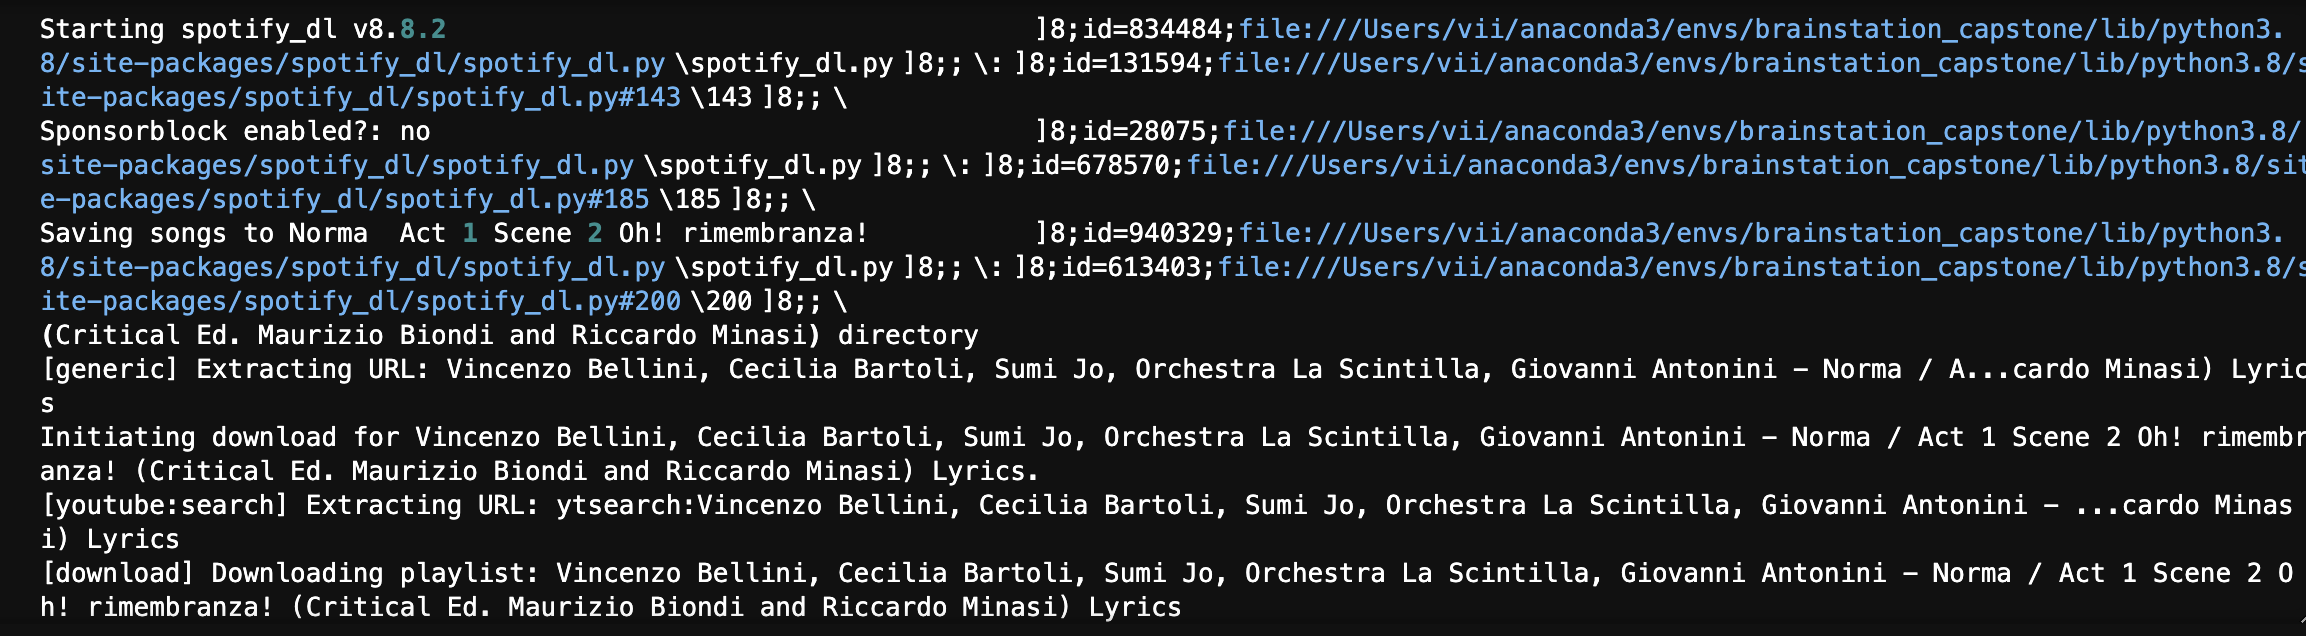

In [8]:
# Obtain a random sample of track_ids to feed to the downloader.
# The random state keeps this value constant on repeat runs.
kaggle_df = pd.read_csv("../data/SpotifyFeatures.csv")
track_ids = (
    kaggle_df.sample(30000, random_state=123).track_id.str.strip().unique().tolist()
)
len(track_ids)

28622

The code below is the downloader code, but it has been commented out as it is not necessary to showcase this notebook. However, if one needed to obtain a group of mp3s to train a model, the code below would be necessary. Again, the embedded screenshot above shows what the output would look like. It is also worth mentioning that `spotify_dl` is a package that outputs to `stdout` and the outputs shown here will also appear within the command line whereever the notebook or lab server is being run.

In [7]:
# os.system("export SPOTIPY_CLIENT_ID={}".format(CLIENT_ID))
# os.system('export SPOTIPY_CLIENT_SECRET={}'.format(CLIENT_SECRET))
# count = 0
# while count<12000:
#     for track_id in track_ids:
#         if (len(track_dirs)>0) & (track_id in track_dirs):
#             count+=1
#             print(f'{count}: {track_id} already downloaded...skipping....')
#         else:
#             url = base_url+track_id    
#             os.system("spotify_dl --url {} -o ../data/mp3s/{}".format(url,track_id))
#             count+=1
#             time.sleep(10) # 10 second delay between requests

[download] Destination: ../data/mp3s/03d0k6VDHR3YCPwWzmeFGE/Nocturne No.1 in E flat, Op.33, No.1/Gabriel Fauré, Pascal Rogé - Nocturne No.1 in E flat, Op.33, No.1.m4a
[download] 100% of    7.16MiB in 00:00:01 at 4.58MiB/s   
[FixupM4a] Correcting container of "../data/mp3s/03d0k6VDHR3YCPwWzmeFGE/Nocturne No.1 in E flat, Op.33, No.1/Gabriel Fauré, Pascal Rogé - Nocturne No.1 in E flat, Op.33, No.1.m4a"
[ExtractAudio] Destination: ../data/mp3s/03d0k6VDHR3YCPwWzmeFGE/Nocturne No.1 in E flat, Op.33, No.1/Gabriel Fauré, Pascal Rogé - Nocturne No.1 in E flat, Op.33, No.1.mp3
Deleting original file ../data/mp3s/03d0k6VDHR3YCPwWzmeFGE/Nocturne No.1 in E flat, Op.33, No.1/Gabriel Fauré, Pascal Rogé - Nocturne No.1 in E flat, Op.33, No.1.m4a (pass -k to keep)
[download] Finished downloading playlist: Gabriel Fauré, Pascal Rogé - Nocturne No.1 in E flat, Op.33, No.1 Lyrics
Download completed in 9.45 seconds.                            ]8;id=799585;file:///Users/vii/anaconda3/envs/brainstation_ca

KeyboardInterrupt: 

[Back to Table of Contents](#toc)

## 5. Exploratory Data Analysis (EDA) <a class="anchor" id="5"></a>

### 5.1 Kaggle Dataset Exploration <a class="anchor" id="5_1"></a>

The dataset from Kaggle is explored in below. The data contains 232,725 rows which is comprised of 176,774 unique `track_id`. For this project, a random sample of 30,000 rows was extracted. From these 28,622 unique `track_id` are present. The unique `track_id` are stripped of trailing and leading spaces before being put into a list for looping. This list of `track_id` was also useful for creating playlists within Spotify to gauge The EDA performed on this dataset is presented below.

In [9]:
kaggle_df.head()

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737             0.000  F#    0.1510    -5.559  Minor   
2       170267   0.131             0.000   C    0.1030   -13.879  Minor   
3       152427   0.326             0.000  C#    0.0985   -12.178  Major   
4        82625   0.225             0.123   F    0.2020   -21.150  Major   

   speechiness    tempo time_signature  valence  
0       0.0525  166.969          4-Apr    0.814  
1       0.0868  174.003          4-Apr    0.816  
2       0.0362   99.488          4-May    0.368  
3       0.0395  171.758          4-Apr    0.227  
4       0.0456  140.576          4-Apr    0.390

Conveniently, all of the columns are lowercase and have had their space characters replaced by _ characters. The info function also reveals that there are no nulls in the dataframe either as the number of non-null values is equal to the row count for the dataframe.

In [10]:
kaggle_df.shape

(232725, 18)

In [11]:
kaggle_df.columns

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

In [12]:
kaggle_df.info()
# There are no nulls within the Kaggle dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [13]:
kaggle_df.genre.value_counts(
    normalize=True
) * 100  # relatively good balance between genres

Comedy              4.159845
Soundtrack          4.144806
Indie               4.100548
Jazz                4.056719
Pop                 4.033086
Electronic          4.029219
Children’s Music    4.018906
Folk                3.995703
Hip-Hop             3.993984
Rock                3.984101
Alternative         3.980234
Classical           3.977226
Rap                 3.966914
World               3.908476
Soul                3.905468
Blues               3.877108
R&B                 3.863788
Anime               3.839725
Reggaeton           3.835858
Ska                 3.813084
Reggae              3.768826
Dance               3.738747
Country             3.722849
Opera               3.557847
Movie               3.354173
Children's Music    2.321624
A Capella           0.051133
Name: genre, dtype: float64

Text(0.5, 1.0, 'Distribution of Genres in Kaggle Dataset')

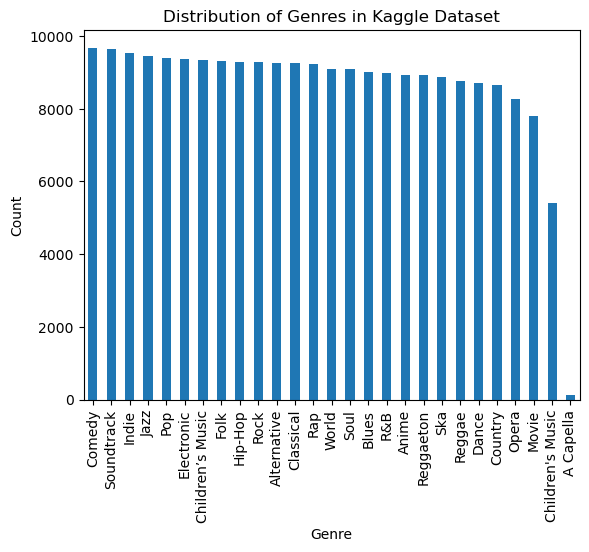

In [14]:
# Genre Distribution
plt.figure()
kaggle_df.genre.value_counts().plot(kind="bar")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Distribution of Genres in Kaggle Dataset")

In [15]:
kaggle_df.duration_ms.value_counts(
    bins=20
)  # most songs are of a short duration, but there are some clear outliers that are much longer

(9849.469, 292263.5]      193597
(292263.5, 569140.0]       36288
(569140.0, 846016.5]        2099
(846016.5, 1122893.0]        404
(1122893.0, 1399769.5]       150
(1399769.5, 1676646.0]        56
(1676646.0, 1953522.5]        24
(2230399.0, 2507275.5]        21
(3061028.5, 3337905.0]        14
(3337905.0, 3614781.5]        12
(2784152.0, 3061028.5]        12
(2507275.5, 2784152.0]        12
(1953522.5, 2230399.0]        12
(3614781.5, 3891658.0]         9
(4722287.5, 4999164.0]         4
(3891658.0, 4168534.5]         3
(4168534.5, 4445411.0]         3
(4445411.0, 4722287.5]         3
(5276040.5, 5552917.0]         2
(4999164.0, 5276040.5]         0
Name: duration_ms, dtype: int64

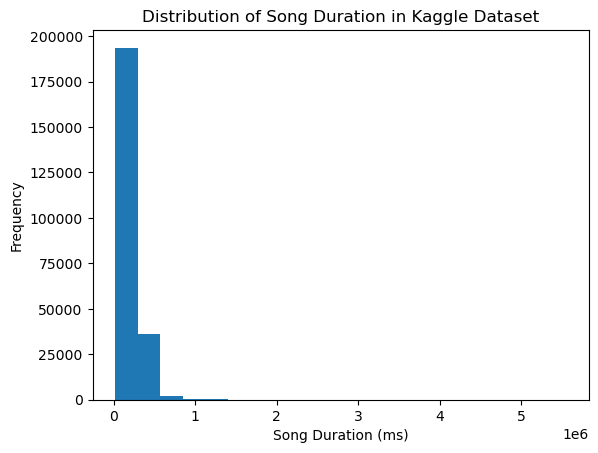

In [16]:
plt.figure()
kaggle_df.duration_ms.plot(kind="hist", bins=20)
plt.xlabel("Song Duration (ms)")
plt.title("Distribution of Song Duration in Kaggle Dataset")
plt.show()

In [17]:
kaggle_df.track_id.nunique()  # there are fewer track ids than there are rows

176774

Some of the track_ids appear more than once.

In [23]:
kaggle_df.track_id.value_counts(ascending=False).head()
# This seemed odd considering that the track_id should be a unique identifier.

3R73Y7X53MIQZWnKloWq5i    8
0wY9rA9fJkuESyYm9uzVK5    8
6sVQNUvcVFTXvlk3ec0ngd    8
0UE0RhnRaEYsiYgXpyLoZc    8
6AIte2Iej1QKlaofpjCzW1    8
Name: track_id, dtype: int64

The following two examples for `track_id` `3R73Y7X53MIQZWnKloWq5i` and `track_id` `2qtoRFCOEL1gRn5q9DJC7F`, respectively, show that a single track_id does correspond to a single song, but that the song can repeat within the data set based on the genre. All of the other columns are identical.

In [24]:
kaggle_df.loc[kaggle_df.track_id == "3R73Y7X53MIQZWnKloWq5i"]

genre artist_name               track_name  \
5506         Alternative  Toro y Moi  Monte Carlo (feat. WET)   
15615              Dance  Toro y Moi  Monte Carlo (feat. WET)   
41367               Folk  Toro y Moi  Monte Carlo (feat. WET)   
55106                R&B  Toro y Moi  Monte Carlo (feat. WET)   
77769   Children’s Music  Toro y Moi  Monte Carlo (feat. WET)   
94721              Indie  Toro y Moi  Monte Carlo (feat. WET)   
149585               Pop  Toro y Moi  Monte Carlo (feat. WET)   
225238              Rock  Toro y Moi  Monte Carlo (feat. WET)   

                      track_id  popularity  acousticness  danceability  \
5506    3R73Y7X53MIQZWnKloWq5i          50        0.0821         0.653   
15615   3R73Y7X53MIQZWnKloWq5i          61        0.0821         0.653   
41367   3R73Y7X53MIQZWnKloWq5i          61        0.0821         0.653   
55106   3R73Y7X53MIQZWnKloWq5i          61        0.0821         0.653   
77769   3R73Y7X53MIQZWnKloWq5i          61        0.0821         0.653   
94721   3R73Y7X53MIQZWnKloWq5i          61        0.0821         0.653   
149585  3R73Y7X53MIQZWnKloWq5i          61        0.0821         0.653   
225238  3R73Y7X53MIQZWnKloWq5i          61        0.0821         0.653   

        duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
5506         125133   0.381          0.000073  C#     0.175    -8.967  Major   
15615        125133   0.381          0.000073  C#     0.175    -8.967  Major   
41367        125133   0.381          0.000073  C#     0.175    -8.967  Major   
55106        125133   0.381          0.000073  C#     0.175    -8.967  Major   
77769        125133   0.381          0.000073  C#     0.175    -8.967  Major   
94721        125133   0.381          0.000073  C#     0.175    -8.967  Major   
149585       125133   0.381          0.000073  C#     0.175    -8.967  Major   
225238       125133   0.381          0.000073  C#     0.175    -8.967  Major   

        speechiness   tempo time_signature  valence  
5506         0.0512  140.08          4-Apr    0.133  
15615        0.0512  140.08          4-Apr    0.133  
41367        0.0512  140.08          4-Apr    0.133  
55106        0.0512  140.08          4-Apr    0.133  
77769        0.0512  140.08          4-Apr    0.133  
94721        0.0512  140.08          4-Apr    0.133  
149585       0.0512  140.08          4-Apr    0.133  
225238       0.0512  140.08          4-Apr    0.133

In [25]:
kaggle_df.loc[kaggle_df.track_id == "2qtoRFCOEL1gRn5q9DJC7F"]

genre  artist_name      track_name                track_id  \
3042         Alternative  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   
55038                R&B  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   
69075            Hip-Hop  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   
78415   Children’s Music  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   
116591               Rap  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   
149496               Pop  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   
192514              Soul  Frank Ocean  Solo (Reprise)  2qtoRFCOEL1gRn5q9DJC7F   

        popularity  acousticness  danceability  duration_ms  energy  \
3042            58         0.404         0.541        78743   0.747   
55038           63         0.404         0.541        78743   0.747   
69075           63         0.404         0.541        78743   0.747   
78415           62         0.404         0.541        78743   0.747   
116591          63         0.404         0.541        78743   0.747   
149496          63         0.404         0.541        78743   0.747   
192514          63         0.404         0.541        78743   0.747   

        instrumentalness key  liveness  loudness   mode  speechiness   tempo  \
3042                 0.0   G     0.086    -6.811  Minor        0.162  83.286   
55038                0.0   G     0.086    -6.811  Minor        0.162  83.286   
69075                0.0   G     0.086    -6.811  Minor        0.162  83.286   
78415                0.0   G     0.086    -6.811  Minor        0.162  83.286   
116591               0.0   G     0.086    -6.811  Minor        0.162  83.286   
149496               0.0   G     0.086    -6.811  Minor        0.162  83.286   
192514               0.0   G     0.086    -6.811  Minor        0.162  83.286   

       time_signature  valence  
3042            4-Apr    0.604  
55038           4-Apr    0.604  
69075           4-Apr    0.604  
78415           4-Apr    0.604  
116591          4-Apr    0.604  
149496          4-Apr    0.604  
192514          4-Apr    0.604

This is a biproduct of how the data was originally obtained.

In [26]:
kaggle_df.loc[kaggle_df.popularity > 20].sort_values(
    by="popularity", ascending=False
).shape[0] / kaggle_df.shape[0] * 100
# roughly 86% of the dataset is above a popularity score of 20
# this means that ~14% is below 20

86.06080137501343

[Back to Table of Contents](#toc)

### 5.2 Librosa Spectrograms <a class="anchor" id="5_2"></a>

The `librosa` package meaasures specific spectra from audio signals. The output is a vectorized spectrum that can then be used within a model. 

#### 5.2.1 Mel Spectrogram <a class="anchor" id="5_2_1"></a>

Melodic spectrum that contains both the harmonic and percussive elements. It is scaled based on the Mel scale, a means of transforming frequency information into a logarithmic scale that more accurately measures pitch. The formula for this is the following:
$$
  {\displaystyle m=2595\log _{10}\left(1+{\frac {f}{700}}\right)=1127\ln \left(1+{\frac {f}{700}}\right)}
$$
For our purposes, the Mel spectrogram is converted from a power spectrum into a decibel spectrum to be more in line with the human hearing.

* https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
* https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html

#### 5.2.2 Mel Frequency Cepstral Coefficients (MFCC) <a class="anchor" id="5_2_2"></a>

Power spectrum coefficients (energy density of sound). The MFCC is often viewed as a subset of the Mel Spectrogram. Again, like the Mel spectrogram above, these coefficients are expressed in decibels.
* https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

#### 5.2.3 Chroma Vector <a class="anchor" id="5_2_3"></a>

Pitch-class profile that shows the individual notes that are played over time.
* https://en.wikipedia.org/wiki/Chroma_feature
* https://librosa.org/doc/latest/generated/librosa.feature.chroma_stft.html

#### 5.2.4 Tonnal Centroid Features (Tonnetz) Spectrum <a class="anchor" id="5_2_4"></a>

Lattice that represents tonal space that was first conceptualized by Euler in 1739. For this project, the tonnetz contains three components:
* Major 3rd
* Minor 3rd
* Perfect 5th
    * These 2-D vectorized elements are then further broken down into x and y components.
* https://en.wikipedia.org/wiki/Tonnetz
* https://librosa.org/doc/latest/generated/librosa.feature.tonnetz.html

NOTE: All sources relevant to this project also available within the README for this project within the Credits & References section.

[Back to Table of Contents](#toc)

Below the code to create the four spectra is adapted from [this tutorial on training a classification model using Keras](https://blog.paperspace.com/music-genre-classification-using-librosa-and-pytorch/).

Two examples are shown below. The first is "Take On Me" by Weezer and the second is "Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango" as performed by the London Syphony Orchestra. These tracks were selected at random from the dataset. For each track, four spectra are depicted. The information for each spectra along with a brief description and the references for each are listed below:

In [5]:
# The sampling rate must be explicitly passed to every function
# This includes the display function itself!
# Hence, the sampling rate is now an output from the function itself
def get_mfcc(y, sr):
    mfcc = librosa.power_to_db(librosa.feature.mfcc(y=y, sr=sr), ref=np.max)
    return mfcc


def get_melspectrogram(y, sr):
    melspectrogram = librosa.power_to_db(
        librosa.feature.melspectrogram(y=y, sr=sr), ref=np.max
    )
    # this is a power spectrum (amplitude squared)
    return melspectrogram


def get_chroma_vector(y, sr):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    return chroma


def get_tonnetz(y, sr):
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    return tonnetz


def get_feature(input_file_path, track_id):
    # Load data
    y, sr = librosa.load(
        input_file_path,
        sr=None,
        offset=10,
        duration=120,
    )
    # Extracting MFCC feature
    mfcc = get_mfcc(y, sr)
    # Move save step to this point!
    np.save(f"../data/vectorized_mp3s/raw/mfcc_{track_id}.npy", mfcc)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_min = mfcc.min(axis=1)
    mfcc_max = mfcc.max(axis=1)
    mfcc_feature = np.concatenate((mfcc_mean, mfcc_min, mfcc_max))

    # Need to move the save to before the reduction of features

    # Extracting Mel Spectrogram feature
    melspectrogram = get_melspectrogram(y, sr)
    np.save(
        f"../data/vectorized_mp3s/raw/melspectrogram_{track_id}.npy",
        melspectrogram,
    )
    melspectrogram_mean = melspectrogram.mean(axis=1)
    melspectrogram_min = melspectrogram.min(axis=1)
    melspectrogram_max = melspectrogram.max(axis=1)
    melspectrogram_feature = np.concatenate(
        (melspectrogram_mean, melspectrogram_min, melspectrogram_max)
    )

    # Extracting chroma vector feature
    chroma = get_chroma_vector(y, sr)
    np.save(f"../data/vectorized_mp3s/raw/chroma_{track_id}.npy", chroma)
    chroma_mean = chroma.mean(axis=1)
    chroma_min = chroma.min(axis=1)
    chroma_max = chroma.max(axis=1)
    chroma_feature = np.concatenate((chroma_mean, chroma_min, chroma_max))

    # Extracting tonnetz feature
    tntz = get_tonnetz(y, sr)
    np.save(f"../data/vectorized_mp3s/raw/tonnetz_{track_id}.npy", tntz)
    tntz_mean = tntz.mean(axis=1)
    tntz_min = tntz.min(axis=1)
    tntz_max = tntz.max(axis=1)
    tntz_feature = np.concatenate((tntz_mean, tntz_min, tntz_max))

    # return chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature
    # this returns both the pairwise vector feature and the CNN feature
    pairwise_feature = np.concatenate(
        (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature)
    )
    height = 224
    width = 224
    mel_resize = resize(melspectrogram, (height, width))
    chroma_resize = resize(chroma, (height, width))
    tntz_resize = resize(tntz, (height, width))
    layers = [mel_resize, chroma_resize, tntz_resize]
    image_stack = []
    for layer in layers:
        max_val = layer.max()
        min_val = layer.min()
        range = max_val - min_val
        range = max(range, 1.0)
        # need to have this to handle division by 0
        norm = (layer - min_val) / range
        image_stack.append(norm.astype(np.float32))
    cnn_feature = np.dstack(image_stack)
    return pairwise_feature, cnn_feature

In [3]:
weezer_example = "/Users/vii/repos/brainstation_capstone/data/mp3s/1ZB2qWsheGabSEYvBYxjKn/Take on Me/Weezer - Take on Me.mp3"

In [288]:
# Load Weezer - Take on Me.mp3
y, sr = librosa.load(
    weezer_example,
    sr=None,
    offset=10,
    duration=120,
)

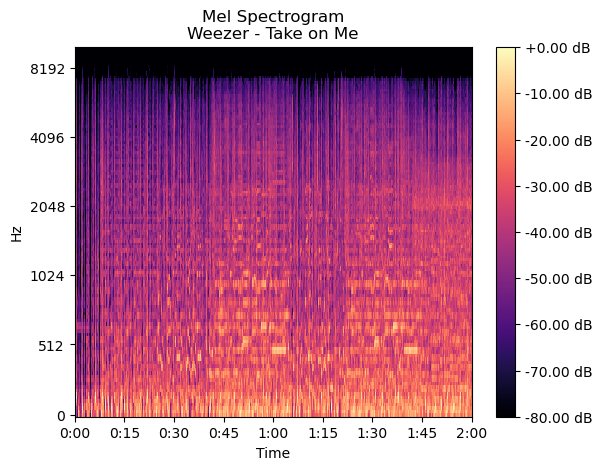

In [289]:
# Melodic Spectrum
melspectrogram = get_melspectrogram(y, sr)
librosa.display.specshow(melspectrogram, sr=sr, y_axis="mel", fmax=10000, x_axis="time")
plt.title("Mel Spectrogram\nWeezer - Take on Me")
plt.colorbar(format="%+2.2f dB")
plt.show()

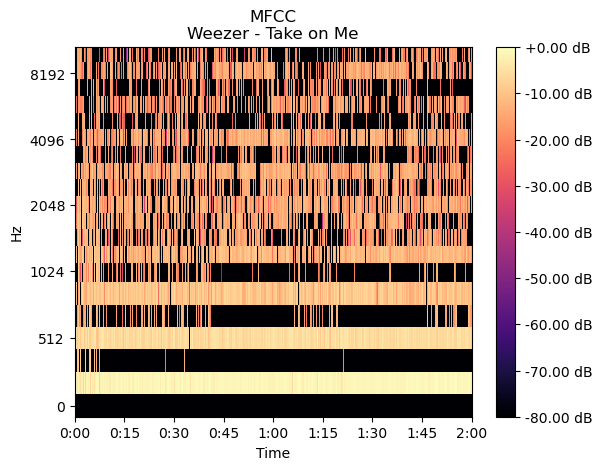

In [290]:
# Mel Frequency Cepstral Coefficients (MFCC)
mfcc = get_mfcc(y, sr)
librosa.display.specshow(
    mfcc,
    sr=sr,
    y_axis="mel",
    fmax=10000,
    x_axis="time",
)
plt.title("MFCC\nWeezer - Take on Me")
plt.colorbar(format="%+2.2f dB")
plt.show()

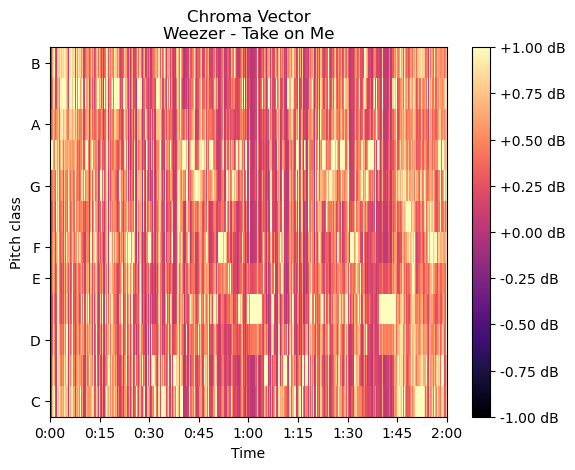

In [291]:
# Pitch-class profile
chroma = get_chroma_vector(y, sr)
librosa.display.specshow(
    chroma, sr=sr, y_axis="chroma", fmax=10000, x_axis="time", vmin=-1, vmax=1
)
plt.title("Chroma Vector\nWeezer - Take on Me")
plt.colorbar(format="%+2.2f dB")
plt.show()

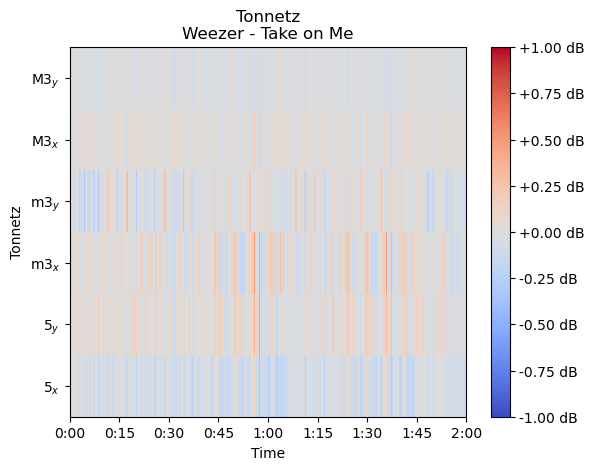

In [292]:
# Tonal Lattice
tntz = get_tonnetz(y, sr)
librosa.display.specshow(
    tntz, sr=sr, y_axis="tonnetz", fmax=10000, x_axis="time", vmin=-1, vmax=1
)
plt.title("Tonnetz\nWeezer - Take on Me")
plt.colorbar(format="%+2.2f dB")
plt.show()

[Back to Table of Contents](#toc)

In [28]:
lso_example = "/Users/vii/repos/brainstation_capstone/data/mp3s/1cjvpB46mcjPIt9KFktKwk/Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango/Giuseppe Verdi, Sherrill Milnes, London Symphony Orchestra, Richard Bonynge - #Rigoletto # Act 2# ##Cortigiani, vil razza dannata...Ebben piango###.mp3"

In [89]:
# Load LSO - Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango.mp3
y, sr = librosa.load(
    lso_example,
    sr=None,
    offset=10,
    duration=120,
)

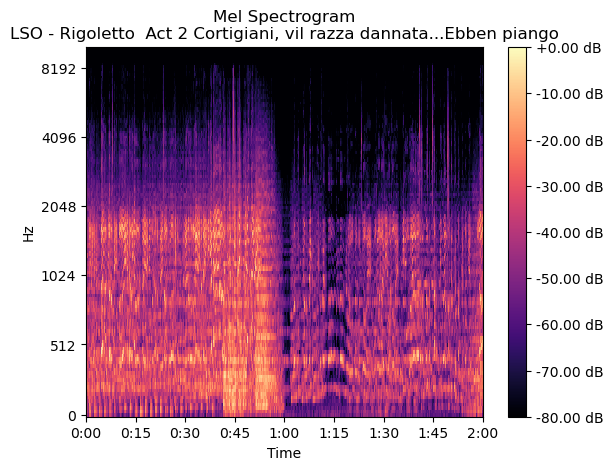

In [90]:
# Melodic Spectrum
melspectrogram = get_melspectrogram(y, sr)
librosa.display.specshow(melspectrogram, sr=sr, y_axis="mel", fmax=10000, x_axis="time")
plt.title(
    "Mel Spectrogram\nLSO - Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango"
)
plt.colorbar(format="%+2.2f dB")
plt.show()

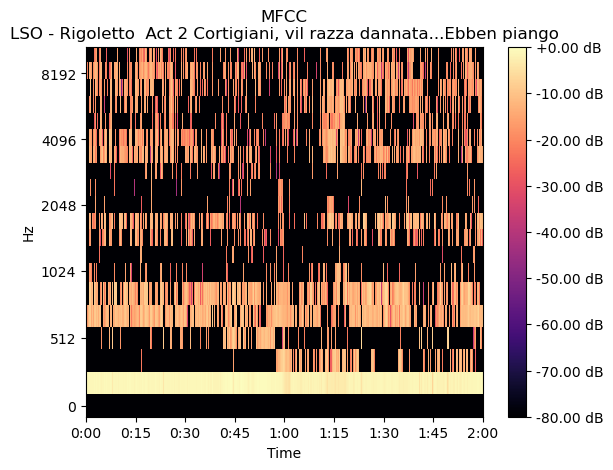

In [91]:
# Mel Frequency Cepstral Coefficients (MFCC)
mfcc = get_mfcc(y, sr)
librosa.display.specshow(mfcc, sr=sr, y_axis="mel", fmax=10000, x_axis="time")
plt.title("MFCC\nLSO - Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango")
plt.colorbar(format="%+2.2f dB")
plt.show()

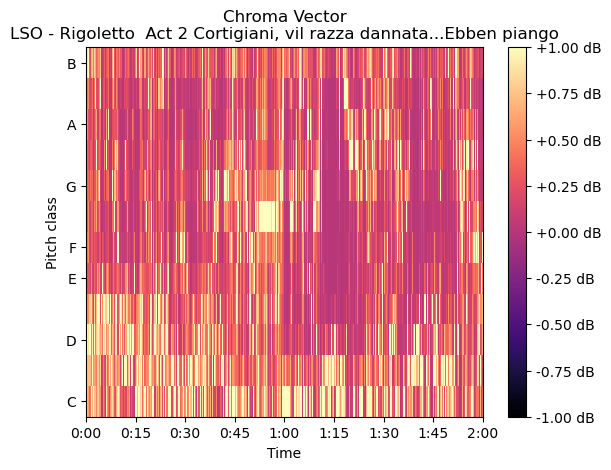

In [92]:
# Pitch-class profile
chroma = get_chroma_vector(y, sr)
librosa.display.specshow(
    chroma, sr=sr, y_axis="chroma", fmax=10000, x_axis="time", vmin=-1, vmax=1
)
plt.title(
    "Chroma Vector\nLSO - Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango"
)
plt.colorbar(format="%+2.2f dB")
plt.show()

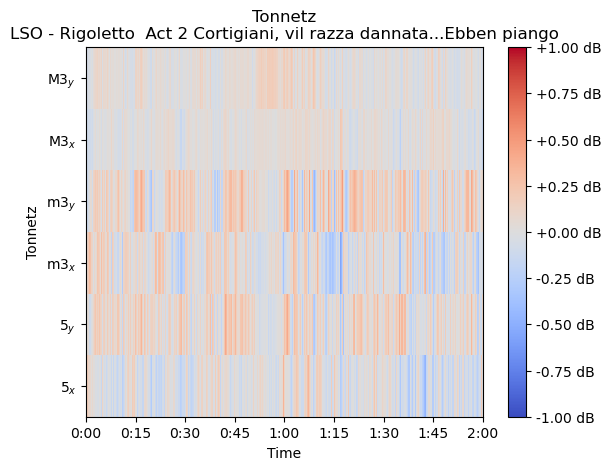

In [93]:
# Tonal Lattice
tntz = get_tonnetz(y, sr)
librosa.display.specshow(
    tntz, sr=sr, y_axis="tonnetz", fmax=10000, x_axis="time", vmin=-1, vmax=1
)
plt.title(
    "Tonnetz\nLSO - Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango"
)
plt.colorbar(format="%+2.2f dB")
plt.show()

[Back to Table of Contents](#toc)

## 6. CNN Model Setup <a class="anchor" id="6"></a>

The following code sets up the model parameters for the convolutional neural network (CNN) model that was also used alongside a calculation of pairwise similarity from just the mean, max, and min for each audio file's spectra. Here the `ResNet50V2` model is used from the `tensorflow` package. This model was choosen since it was presented as a suitable off-the-shelf model for image based analysis. 

In [95]:
def set_random_seed(seed):
    """Random seeds for reproducability"""

    random.seed(seed)
    tf.random.set_seed(seed)

In [96]:
height = 224
width = 224
channels = 3
res_model = ResNet50V2(
    weights="imagenet", include_top=True, input_shape=(height, width, channels)
)
res_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [97]:
# Freeze all the layers in the base model
for layer in res_model.layers:
    layer.trainable = False

In [98]:
# For image analysis we only need to flatten for embedding
set_random_seed(121)
res_out = res_model.output
output = Flatten()(res_out)

In [99]:
model = Model(inputs=res_model.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

[Back to Table of Contents](#toc)

### 6.1 CNN Image Visualization <a class="anchor" id="6_1"></a>

An example output of the stacking of the spectra used to create an image for the CNN is below. The previous example of 'Take on Me' by Weezer is shown. The Mel Spectrum, Chroma, and Tonnetz are layered together in place of the RGB layers that would be present normally. This creates a multicolored image. Additionally, "Aware" by Green Assassin Dollar is also shown, as it is an example used for demonstration purposes later.

In [8]:
green_assassin_example =  "/Users/vii/repos/brainstation_capstone/data/mp3s/2QbR9yeeX7XHznRZwsyh3F/Aware/Green Assassin Dollar - Aware.mp3"

<Figure size 640x480 with 0 Axes>

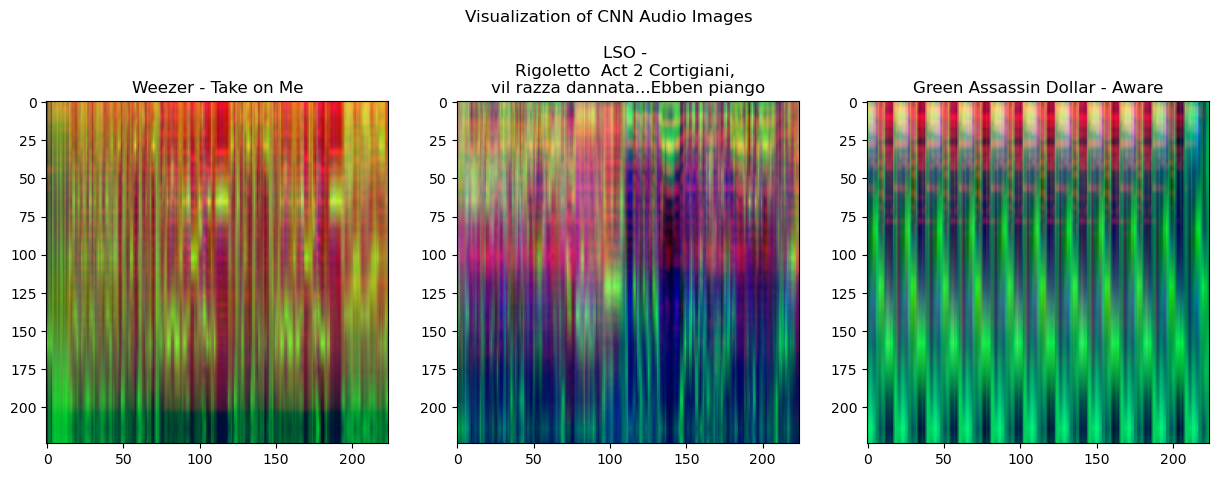

In [42]:
# Weezer Example
plt.figure()
y, sr = librosa.load(
    weezer_example,
    sr=None,
    offset=10,
    duration=120,
)
height = 224
width = 224
melspectrogram = get_melspectrogram(y, sr)
chroma = get_chroma_vector(y, sr)
tntz = get_tonnetz(y, sr)
mel_resize = resize(melspectrogram, (height, width))
chroma_resize = resize(chroma, (height, width))
tntz_resize = resize(tntz, (height, width))
layers = [mel_resize, chroma_resize, tntz_resize]
image_stack = []
for layer in layers:
    max_val = layer.max()
    min_val = layer.min()
    range = max_val - min_val
    range = max(range, 1.0)
    # need to have this to handle division by 0
    norm = (layer - min_val) / range
    image_stack.append(norm.astype(np.float32))
cnn_feature = np.dstack(image_stack)
plt.subplots(1,3, figsize=(15, 15),)
plt.suptitle('Visualization of CNN Audio Images', y=0.67, horizontalalignment='center')
plt.subplot(1,3,1)
plt.imshow(cnn_feature)
plt.title('Weezer - Take on Me')



# LSO Example
y, sr = librosa.load(
    lso_example,
    sr=None,
    offset=10,
    duration=120,
)
height = 224
width = 224
melspectrogram = get_melspectrogram(y, sr)
chroma = get_chroma_vector(y, sr)
tntz = get_tonnetz(y, sr)
mel_resize = resize(melspectrogram, (height, width))
chroma_resize = resize(chroma, (height, width))
tntz_resize = resize(tntz, (height, width))
layers = [mel_resize, chroma_resize, tntz_resize]
image_stack = []
for layer in layers:
    max_val = layer.max()
    min_val = layer.min()
    range = max_val - min_val
    range = max(range, 1.0)
    # need to have this to handle division by 0
    norm = (layer - min_val) / range
    image_stack.append(norm.astype(np.float32))
cnn_feature = np.dstack(image_stack)
plt.subplot(1,3,2)
plt.imshow(cnn_feature)
plt.title('LSO - \nRigoletto  Act 2 Cortigiani, \nvil razza dannata...Ebben piango')

# Green Assassin Dollar Example
y, sr = librosa.load(
    green_assassin_example,
    sr=None,
    offset=10,
    duration=120,
)
height = 224
width = 224
melspectrogram = get_melspectrogram(y, sr)
chroma = get_chroma_vector(y, sr)
tntz = get_tonnetz(y, sr)
mel_resize = resize(melspectrogram, (height, width))
chroma_resize = resize(chroma, (height, width))
tntz_resize = resize(tntz, (height, width))
layers = [mel_resize, chroma_resize, tntz_resize]
image_stack = []
for layer in layers:
    max_val = layer.max()
    min_val = layer.min()
    range = max_val - min_val
    range = max(range, 1.0)
    # need to have this to handle division by 0
    norm = (layer - min_val) / range
    image_stack.append(norm.astype(np.float32))
cnn_feature = np.dstack(image_stack)
plt.subplot(1,3,3)
plt.imshow(cnn_feature)
plt.title('Green Assassin Dollar - Aware')
# Outputs figure for use in README
# This code does not need to be run and was added for my own use
# plt.savefig('../reports/images/20230904_readme_splash.png', bbox_inches = 'tight', dpi=300)
plt.show()

[Back to Table of Contents](#toc)

## 7. Vectorizing Data <a class="anchor" id="7"></a>

The code used to vectorize the `.mp3` files is found below. First it uses a glob object from the `pathlib` library to recursively find all of the mp3s that successfully downloaded. Note that during this process two of the more than 11,500 mp3s did not download correctly from the downloader code and produced a file that could not be parsed. These files had to subsequently be deleted in order to prevent the code from halting due to errors. There is also a list created from the mp3s that have already been converted. This allows the function to have a resume functionality similar to the downloader which was implemented since it was not known initially how computationally intensive this process would be. Initially, all of the vectorized DataFrames were held in memory and concatenated at once. However, this process began to slow down over time and it was decided instead to write out each file individually and then concatenate everything back together once the vectorization had completed. 

Each song is converted into an 498-dimensional vector using the `get_feature` function defined above. It should also be noted that for the functions that require a time duration, each song is given a 10 second offset along with a 120 second audio sample. This helps to standardize the lengths of the mp3 files and also provides ample time to get the main melody or 'hook' of a song. Additionally, this method also normalizes for the volume of each of the songs which can vary depending on the recording. An example output from the vectoziation is shown below as reference. The number indicates the count for the individual mp3 along with the file path for the vectorized data.

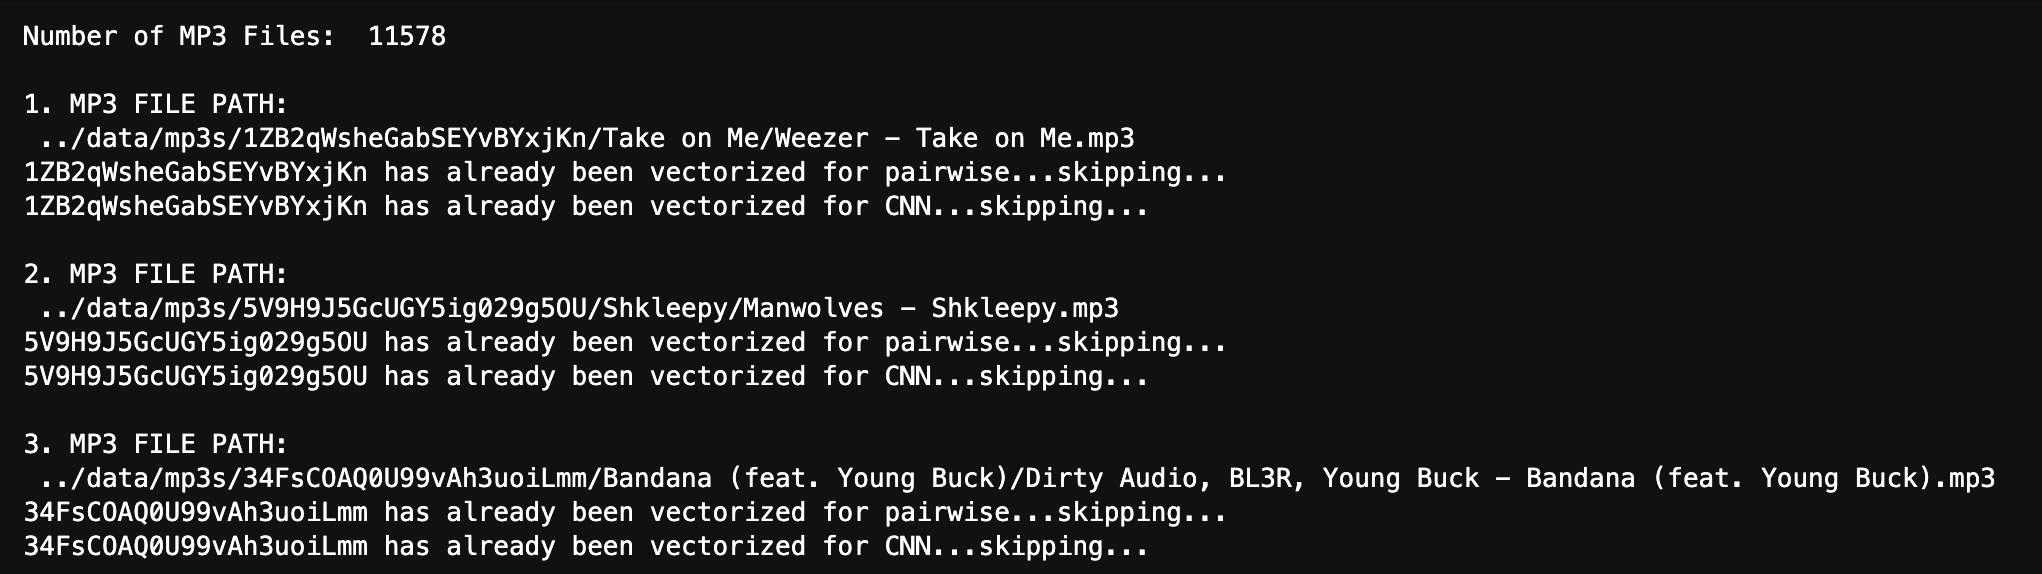

### 7.1 Count MP3s <a class="anchor" id="7_1"></a>

In [321]:
data_dir = Path("../data/mp3s/")
path_glob = data_dir.rglob("*.mp3")
file_paths = [file_path for file_path in path_glob]
track_ids = []
for file_path in file_paths:
    path_split = str(file_path).split("/")
    track_id = path_split[3]
    track_ids.append(track_id)  # creates a list for repeated iteration
    # if this is not done, the .rglob command above has to be repeated to regenerate iterator
len(track_ids)  # number of mp3s in directory

11578

Here, for the sake of reproducibility, the list of unique `track_id` is saved to a `parquet` file so that they can be used again and as a hedge against random seed differences. The code has been commented out to prevent overwriting the existing file. Note that if one wants to retrain the model on a different set of data, then uncommenting this code and recreating this file might be useful.

In [319]:
# track_ids_df = pd.DataFrame({"track_ids": track_ids})
# track_ids_df.to_parquet("../data/20230903_unique_track_ids_for_training.parquet")

[Back to Table of Contents](#toc)

### 7.2 Generate Track Feature Files <a class="anchor" id="7_2"></a>

#### 7.2.1 Normal Pairwise and CNN Matrices <a class="anchor" id="7_2_1"></a>

In [16]:
# This code was no rerun to show the outputs, but is presented here
# for reproducibility and completeness.
# Generator objects need to be rerun each time to prevent exhaustion
data_dir = Path("../data/mp3s/")
output_pairwise_dir = Path("../data/vectorized_mp3s/pairwise_parquets/")
output_cnn_dir = Path("../data/vectorized_mp3s/cnn_parquets/")
data_dir_glob = data_dir.rglob("*.mp3")
output_pairwise_glob = output_pairwise_dir.rglob("*.parquet")
output_cnn_glob = output_cnn_dir.rglob("*.parquet")
count = 1
file_paths = [file_path for file_path in data_dir_glob]
print("Number of MP3 Files: ", len(file_paths), "\n")
pairwise_track_ids = [file_path.stem for file_path in output_pairwise_glob]
cnn_track_ids = [file_path.stem for file_path in output_cnn_glob]
for file_path in file_paths:
    print(f"{count}. MP3 FILE PATH: \n", f"{file_path}")
    path_split = str(file_path).split("/")
    track_id = path_split[3]
    pairwise_track, cnn_track = get_feature(file_path, track_id)
    if (len(pairwise_track_ids) > 0) & (track_id in pairwise_track_ids):
        print(f"{track_id} has already been vectorized for pairwise...skipping...")
    else:
        vectorized_df = pd.DataFrame(pairwise_track).T
        vectorized_df["track_id"] = track_id
        vectorized_df = vectorized_df.set_index(vectorized_df.track_id).drop(
            columns="track_id"
        )
        vectorized_df.columns = vectorized_df.columns.astype(str)
        vectorized_df.to_parquet(
            f"../data/vectorized_mp3s/pairwise_parquets/{track_id}.parquet"
        )
        print(f"{track_id} has been pairwise vectorized!")
    if (len(cnn_track_ids) > 0) & (track_id in cnn_track_ids):
        print(f"{track_id} has already been vectorized for CNN...skipping...\n")
        count += 1
    else:
        cnn_track = np.expand_dims(cnn_track, axis=0)
        cnn_track = model.predict(cnn_track)
        vectorized_df = pd.DataFrame(cnn_track)
        vectorized_df["track_id"] = track_id
        vectorized_df = vectorized_df.set_index(vectorized_df.track_id).drop(
            columns="track_id"
        )
        vectorized_df.columns = vectorized_df.columns.astype(str)
        vectorized_df.to_parquet(
            f"../data/vectorized_mp3s/cnn_parquets/{track_id}.parquet"
        )
        print(f"{track_id} has been CNN vectorized!\n")
        count += 1

Number of MP3 Files:  11578 

1. MP3 FILE PATH: 
 ../data/mp3s/1ZB2qWsheGabSEYvBYxjKn/Take on Me/Weezer - Take on Me.mp3
1ZB2qWsheGabSEYvBYxjKn has already been vectorized for pairwise...skipping...
1ZB2qWsheGabSEYvBYxjKn has already been vectorized for CNN...skipping...

2. MP3 FILE PATH: 
 ../data/mp3s/5V9H9J5GcUGY5ig029g5OU/Shkleepy/Manwolves - Shkleepy.mp3
5V9H9J5GcUGY5ig029g5OU has already been vectorized for pairwise...skipping...
5V9H9J5GcUGY5ig029g5OU has already been vectorized for CNN...skipping...

3. MP3 FILE PATH: 
 ../data/mp3s/34FsCOAQ0U99vAh3uoiLmm/Bandana (feat. Young Buck)/Dirty Audio, BL3R, Young Buck - Bandana (feat. Young Buck).mp3
34FsCOAQ0U99vAh3uoiLmm has already been vectorized for pairwise...skipping...
34FsCOAQ0U99vAh3uoiLmm has already been vectorized for CNN...skipping...

4. MP3 FILE PATH: 
 ../data/mp3s/25mldAmMHYzXhDXCxTpTHy/Chloroform/Phoenix - Chloroform.mp3
25mldAmMHYzXhDXCxTpTHy has already been vectorized for pairwise...skipping...
25mldAmMHYzXhDXCx

63ElaCh1e2AosE7EJAdxfq has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 115ms/step
63ElaCh1e2AosE7EJAdxfq has been CNN vectorized!

858. MP3 FILE PATH: 
 ../data/mp3s/7BDGjDqOuUbZkwDPSXoMl0/Saturday Night/The Cat Empire - Saturday Night.mp3
7BDGjDqOuUbZkwDPSXoMl0 has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 147ms/step
7BDGjDqOuUbZkwDPSXoMl0 has been CNN vectorized!

859. MP3 FILE PATH: 
 ../data/mp3s/6R40BJoXMj9R942vnhuFsS/Kenner Boogie/Jon Batiste - Kenner Boogie.mp3
6R40BJoXMj9R942vnhuFsS has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 124ms/step
6R40BJoXMj9R942vnhuFsS has been CNN vectorized!

860. MP3 FILE PATH: 
 ../data/mp3s/0FeqPtdkwXs54spLxfWnqr/Smoke Ring Halo/The Wood Brothers - Smoke Ring Halo.mp3
0FeqPtdkwXs54spLxfWnqr has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 120ms/step
0F

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


7wobmC9Xz4stYN1ZVLWgi5 has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 128ms/step
7wobmC9Xz4stYN1ZVLWgi5 has been CNN vectorized!

1394. MP3 FILE PATH: 
 ../data/mp3s/3mskluxUoD4xICumdJCR7l/Dave McGillivray/Jeff Beal - Dave McGillivray.mp3
3mskluxUoD4xICumdJCR7l has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 161ms/step
3mskluxUoD4xICumdJCR7l has been CNN vectorized!

1395. MP3 FILE PATH: 
 ../data/mp3s/0XVQTr58DZbLUcjacnTp8k/Madness/Ruelle - Madness.mp3
0XVQTr58DZbLUcjacnTp8k has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 125ms/step
0XVQTr58DZbLUcjacnTp8k has been CNN vectorized!

1396. MP3 FILE PATH: 
 ../data/mp3s/18765csbulflFn1Ww4bcys/Change/Clay Walker - Change.mp3
18765csbulflFn1Ww4bcys has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 148ms/step
18765csbulflFn1Ww4bcys has been CNN vecto

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


0vybyrCk6ANFFmDTBWq74f has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 114ms/step
0vybyrCk6ANFFmDTBWq74f has been CNN vectorized!

2682. MP3 FILE PATH: 
 ../data/mp3s/2cgZfcnb639TaZhd1AU8iz/Bun Up the Dance/Dillon Francis, Skrillex - Bun Up the Dance.mp3
2cgZfcnb639TaZhd1AU8iz has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 135ms/step
2cgZfcnb639TaZhd1AU8iz has been CNN vectorized!

2683. MP3 FILE PATH: 
 ../data/mp3s/6l4qV9VNeCOesvcLPJMO9y/ - .mp3
6l4qV9VNeCOesvcLPJMO9y has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 133ms/step
6l4qV9VNeCOesvcLPJMO9y has been CNN vectorized!

2684. MP3 FILE PATH: 
 ../data/mp3s/3DusC19xQoOt98IVXnH9uS/Corporate Cafeteria (Acoustic)/The Expendables - Corporate Cafeteria (Acoustic).mp3
3DusC19xQoOt98IVXnH9uS has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 121ms/

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


2SNtwYtk9a4THKlERP0bMN has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 140ms/step
2SNtwYtk9a4THKlERP0bMN has been CNN vectorized!

4932. MP3 FILE PATH: 
 ../data/mp3s/3RDcUlLGp3SLp2AmUbUbls/Cookie Jar (feat. The-Dream)/Gym Class Heroes, The-Dream - Cookie Jar (feat. The-Dream).mp3
3RDcUlLGp3SLp2AmUbUbls has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 135ms/step
3RDcUlLGp3SLp2AmUbUbls has been CNN vectorized!

4933. MP3 FILE PATH: 
 ../data/mp3s/0lb0z6jpnOO5qYVayvqWoh/Past Life Melodies/The American Boychoir - Past Life Melodies.mp3
0lb0z6jpnOO5qYVayvqWoh has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 129ms/step
0lb0z6jpnOO5qYVayvqWoh has been CNN vectorized!

4934. MP3 FILE PATH: 
 ../data/mp3s/0rU4dLUSToe7uQUfaFCoda/3 Romances sans paroles, Op. 17 No. 3, Andante moderato in A-Flat Major/Gabriel Fauré, Christine Croshaw - 3 Romances sans pa

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


2C6FKqjI3CT4Q0YjOlAQAl has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 116ms/step
2C6FKqjI3CT4Q0YjOlAQAl has been CNN vectorized!

6683. MP3 FILE PATH: 
 ../data/mp3s/0xMd5bcWTbyXS7wPrBtZA6/Burn/Ellie Goulding - Burn.mp3
0xMd5bcWTbyXS7wPrBtZA6 has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 116ms/step
0xMd5bcWTbyXS7wPrBtZA6 has been CNN vectorized!

6684. MP3 FILE PATH: 
 ../data/mp3s/3blJWKRuT9BPPSi1xN8hHX/Mi Bloncito/Ñejo - Mi Bloncito.mp3
3blJWKRuT9BPPSi1xN8hHX has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 156ms/step
3blJWKRuT9BPPSi1xN8hHX has been CNN vectorized!

6685. MP3 FILE PATH: 
 ../data/mp3s/1eGAZX0TKa5qCxWsvhf8Th/Brick Wall Views/The Lawrence Arms - Brick Wall Views.mp3
1eGAZX0TKa5qCxWsvhf8Th has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 117ms/step
1eGAZX0TKa5qCxWsvhf8Th has b

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


4oarDDCWsSnX2WOIRKuQo1 has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 120ms/step
4oarDDCWsSnX2WOIRKuQo1 has been CNN vectorized!

6975. MP3 FILE PATH: 
 ../data/mp3s/6uv0GnArZDs61ivyZQL7kS/Then (Piano Mix)/Brad Paisley - Then (Piano Mix).mp3
6uv0GnArZDs61ivyZQL7kS has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 126ms/step
6uv0GnArZDs61ivyZQL7kS has been CNN vectorized!

6976. MP3 FILE PATH: 
 ../data/mp3s/3stWWPN41byqp8loPdy92u/Master of None/Beach House - Master of None.mp3
3stWWPN41byqp8loPdy92u has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 137ms/step
3stWWPN41byqp8loPdy92u has been CNN vectorized!

6977. MP3 FILE PATH: 
 ../data/mp3s/0dd2y9eFu1qkAnATCRW0G3/I Gave It All/Aquilo - I Gave It All.mp3
0dd2y9eFu1qkAnATCRW0G3 has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 136ms/step
0dd2y9eFu1

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


11SY8jJkg1CtUgHx37qUlm has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 182ms/step
11SY8jJkg1CtUgHx37qUlm has been CNN vectorized!

7816. MP3 FILE PATH: 
 ../data/mp3s/6QUngYwZ65et2ye7Bj85EK/Can You Get To That/Funkadelic - Can You Get To That.mp3
6QUngYwZ65et2ye7Bj85EK has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 149ms/step
6QUngYwZ65et2ye7Bj85EK has been CNN vectorized!

7817. MP3 FILE PATH: 
 ../data/mp3s/6lKRMylSZMtA7EqPl0pcdI/Are You Satisfied/MARINA - Are You Satisfied#.mp3
6lKRMylSZMtA7EqPl0pcdI has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 140ms/step
6lKRMylSZMtA7EqPl0pcdI has been CNN vectorized!

7818. MP3 FILE PATH: 
 ../data/mp3s/3xnbJVx4QqsOYip8Cn6OrN/Crunch Time/Chris Travis - Crunch Time.mp3
3xnbJVx4QqsOYip8Cn6OrN has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 139ms/step
3x

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


5oICBRkaGVtLTkkKeXuSKF has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 132ms/step
5oICBRkaGVtLTkkKeXuSKF has been CNN vectorized!

7926. MP3 FILE PATH: 
 ../data/mp3s/4kpbrWUW7rznN3mzjCjQUz/Satellite/The Kills - Satellite.mp3
4kpbrWUW7rznN3mzjCjQUz has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 149ms/step
4kpbrWUW7rznN3mzjCjQUz has been CNN vectorized!

7927. MP3 FILE PATH: 
 ../data/mp3s/04G8U1rkNbiiLNsWo2doW2/Monsoon/Amber Mark, Mia Mark - Monsoon.mp3
04G8U1rkNbiiLNsWo2doW2 has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 137ms/step
04G8U1rkNbiiLNsWo2doW2 has been CNN vectorized!

7928. MP3 FILE PATH: 
 ../data/mp3s/3GPD6qjLLDrhb7mUYCV9wT/City Lights/Motionless In White - City Lights.mp3
3GPD6qjLLDrhb7mUYCV9wT has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 145ms/step
3GPD6qjLLDrhb7mUYCV9wT 

4qWzWD48EQ3jQlyVvk9pxa has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 144ms/step
4qWzWD48EQ3jQlyVvk9pxa has been CNN vectorized!

8157. MP3 FILE PATH: 
 ../data/mp3s/1tGKjMflcFTEY2IOzKhwLe/Prove It/Crowder, KB - Prove It.mp3
1tGKjMflcFTEY2IOzKhwLe has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 143ms/step
1tGKjMflcFTEY2IOzKhwLe has been CNN vectorized!

8158. MP3 FILE PATH: 
 ../data/mp3s/1uigwk5hNV84zRd5YQQRTk/Pocketful of Sunshine/Natasha Bedingfield - Pocketful of Sunshine.mp3
1uigwk5hNV84zRd5YQQRTk has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 141ms/step
1uigwk5hNV84zRd5YQQRTk has been CNN vectorized!

8159. MP3 FILE PATH: 
 ../data/mp3s/5CKHhg31HcYYhwUeeGqvhq/I Wish I Knew How It Would Feel to Be Free/Nina Simone - I Wish I Knew How It Would Feel to Be Free.mp3
5CKHhg31HcYYhwUeeGqvhq has already been vectorized for pairwise...skippin

1FPdKaYo5DK8oxCwkUq0GS has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 184ms/step
1FPdKaYo5DK8oxCwkUq0GS has been CNN vectorized!

9225. MP3 FILE PATH: 
 ../data/mp3s/1rOlTL4pKQ9Y1fURua4AJR/My Body Is a Cage/Arcade Fire - My Body Is a Cage.mp3
1rOlTL4pKQ9Y1fURua4AJR has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 137ms/step
1rOlTL4pKQ9Y1fURua4AJR has been CNN vectorized!

9226. MP3 FILE PATH: 
 ../data/mp3s/29chnYiDB5P03F0d5MKKt0/Fight Music/SEKAI NO OWARI - Fight Music.mp3
29chnYiDB5P03F0d5MKKt0 has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 108ms/step
29chnYiDB5P03F0d5MKKt0 has been CNN vectorized!

9227. MP3 FILE PATH: 
 ../data/mp3s/414J8tKHbtF16XOiHGBEso/Tezeta (Nostalgia)/Mulatu Astatke - Tezeta (Nostalgia).mp3
414J8tKHbtF16XOiHGBEso has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 141ms

1uD76u7VzeiplKKmvLEJ43 has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 168ms/step
1uD76u7VzeiplKKmvLEJ43 has been CNN vectorized!

9317. MP3 FILE PATH: 
 ../data/mp3s/2UrILPsnAc5Jh4VLGyFoKx/Symphony No. 4 in E Minor, Op. 98 IV. Allegro energico e passionato - Più allegro/Johannes Brahms, Wiener Philharmoniker, Carlos Kleiber - Symphony No. 4 in E Minor, Op. 98# IV. Allegro energico e passionato - Più allegro.mp3
2UrILPsnAc5Jh4VLGyFoKx has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 133ms/step
2UrILPsnAc5Jh4VLGyFoKx has been CNN vectorized!

9318. MP3 FILE PATH: 
 ../data/mp3s/1bXgMtdwYuFAPApWxGbS17/How Great Is Your Love/Phil Wickham - How Great Is Your Love.mp3
1bXgMtdwYuFAPApWxGbS17 has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 148ms/step
1bXgMtdwYuFAPApWxGbS17 has been CNN vectorized!

9319. MP3 FILE PATH: 
 ../data/mp3s/2pJZ1v8HezrAoZ0

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


6cZ8T2c95NfRTrGEXqThIq has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 150ms/step
6cZ8T2c95NfRTrGEXqThIq has been CNN vectorized!

10165. MP3 FILE PATH: 
 ../data/mp3s/2a7z0RvsjwSMWEPwIWO5z2/La Ultima Vez/Feid - La Ultima Vez.mp3
2a7z0RvsjwSMWEPwIWO5z2 has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 137ms/step
2a7z0RvsjwSMWEPwIWO5z2 has been CNN vectorized!

10166. MP3 FILE PATH: 
 ../data/mp3s/7os1J5P6JqIxKSxq71QuQC/Hero (feat. Christina Perri) - Deep Mix/Cash Cash, Christina Perri - Hero (feat. Christina Perri) - Deep Mix.mp3
7os1J5P6JqIxKSxq71QuQC has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 139ms/step
7os1J5P6JqIxKSxq71QuQC has been CNN vectorized!

10167. MP3 FILE PATH: 
 ../data/mp3s/4qZwVr553XcQNdeqjueeE3/Roses Are Red - Original Version/Aqua - Roses Are Red - Original Version.mp3
4qZwVr553XcQNdeqjueeE3 has already been vectorized 

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


2s9M78CDrQDjB2D827XXr4 has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 129ms/step
2s9M78CDrQDjB2D827XXr4 has been CNN vectorized!

10205. MP3 FILE PATH: 
 ../data/mp3s/3rMyMv8EjKXoPnaRo2hdJN/Stuntin' Like My Daddy - Street/Birdman, Lil Wayne - Stuntin' Like My Daddy - Street.mp3
3rMyMv8EjKXoPnaRo2hdJN has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 124ms/step
3rMyMv8EjKXoPnaRo2hdJN has been CNN vectorized!

10206. MP3 FILE PATH: 
 ../data/mp3s/3UUx0JWEJCbKZvhzpruLfe/Letting You Go/Sara Evans - Letting You Go.mp3
3UUx0JWEJCbKZvhzpruLfe has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 136ms/step
3UUx0JWEJCbKZvhzpruLfe has been CNN vectorized!

10207. MP3 FILE PATH: 
 ../data/mp3s/3As1HTUDBTiTDbwnuICy4C/Fisherman's Horizon Piano Collections Version (From Final Fantasy VIII) [For Piano Solo]/Nobuo Uematsu, daigoro789 - #Fisherman's Horizon# Piano

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=818
  warnings.warn(


4FwxXaVT6iGfhiInzQLJ2n has been CNN vectorized!

11450. MP3 FILE PATH: 
 ../data/mp3s/6QPCo7i6vBXzbdg4muyOdG/Bye Bye Blackbird/Riders In The Sky - Bye Bye Blackbird.mp3
6QPCo7i6vBXzbdg4muyOdG has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 143ms/step
6QPCo7i6vBXzbdg4muyOdG has been CNN vectorized!

11451. MP3 FILE PATH: 
 ../data/mp3s/2v4kQsvlTPEYOIyJkytzGH/In A Sweater Poorly Knit/mewithoutYou - In A Sweater Poorly Knit.mp3
2v4kQsvlTPEYOIyJkytzGH has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 134ms/step
2v4kQsvlTPEYOIyJkytzGH has been CNN vectorized!

11452. MP3 FILE PATH: 
 ../data/mp3s/1eupQ3yeBQPmAUcHyhrXkb/Mal ô mains/Sanseverino - Mal ô mains.mp3
1eupQ3yeBQPmAUcHyhrXkb has already been vectorized for pairwise...skipping...
1/1 [==============================] - 0s 122ms/step
1eupQ3yeBQPmAUcHyhrXkb has been CNN vectorized!

11453. MP3 FILE PATH: 
 ../data/mp3s/6FlgXdr8JJLfQvMoHQjE0r/

[Back to Table of Contents](#toc)

#### 7.2.2 Create Complete Pairwise Parquet <a class="anchor" id="7_2_2"></a>

In [17]:
vectorized_data_path = Path("../data/vectorized_mp3s/pairwise_parquets/")
path_glob = vectorized_data_path.rglob("*.parquet")
dataframes = []
for file_path in path_glob:
    tmp = pd.read_parquet(f"{file_path}")
    dataframes.append(tmp)
vectorized_df = pd.concat(dataframes)

In [18]:
output_file_date = datetime.now().strftime(
    "%Y%m%d"
)  # time stamps the file with the reverse of the date
vectorized_df.to_parquet(
    f"../data/vectorized_mp3s/pairwise_complete_parquets/{output_file_date}_complete_pairwise_data.parquet"
)
assert vectorized_df.shape[0] == 11578

[Back to Table of Contents](#toc)

#### 7.2.3 Create Complete CNN Parquet<a class="anchor" id="7_2_3"></a>

In [19]:
vectorized_data_path = Path("../data/vectorized_mp3s/cnn_parquets/")
path_glob = vectorized_data_path.rglob("*.parquet")
dataframes = []
for file_path in path_glob:
    tmp = pd.read_parquet(f"{file_path}")
    dataframes.append(tmp)
vectorized_df = pd.concat(dataframes)

In [20]:
output_file_date = datetime.now().strftime(
    "%Y%m%d"
)  # time stamps the file with the reverse of the date
vectorized_df.to_parquet(
    f"../data/vectorized_mp3s/cnn_complete_parquets/{output_file_date}_complete_cnn_data.parquet"
)
assert vectorized_df.shape[0] == 11578

[Back to Table of Contents](#toc)

## 8. Pairwise Cosine Similarity <a class="anchor" id="8"></a>

Once the code above generates a complete file containing all of the vectorized mp3s, the file is read in and a pairwise cosine similarity is run using the `pairwise` function from the `sklearn.metrics` library. This array is then sorted in order from most similar to least similar. A vector is then selected from this array and a list is created from the sorted vector. Next, the sorted vector is passed into the vectorized data to extract the tracks that are most similar to the track being asked for by the user. This set of tracks can then be used to create a playlist within Spotify for both the Normal and CNN models. It should also be noted that code was also added to check lists of dissimilarity as well.

### 8.1 Normal Parquet <a class="anchor" id="8_1"></a>

In [101]:
normal_df = pd.read_parquet(
    "../data/vectorized_mp3s/pairwise_complete_parquets/20230901_complete_pairwise_data.parquet"
)
normal_df.shape

(11578, 498)

[Back to Table of Contents](#toc)

### 8.2 CNN Parquet <a class="anchor" id="8_2"></a>

In [102]:
cnn_df = pd.read_parquet(
    "../data/vectorized_mp3s/cnn_complete_parquets/20230901_complete_cnn_data.parquet"
)
cnn_df.shape

(11578, 1000)

[Back to Table of Contents](#toc)

### 8.3 Compute Similarity <a class="anchor" id="8_3"></a>

#### 8.3.1 Normal Similarity <a class="anchor" id="8_3_1"></a>

In [103]:
normal_similarity = pairwise.cosine_similarity(normal_df, dense_output=True)
normal_similarity

array([[1.        , 0.97973231, 0.99154322, ..., 0.98798471, 0.9864652 ,
        0.96577147],
       [0.97973231, 1.        , 0.98947364, ..., 0.98547464, 0.99003342,
        0.98766516],
       [0.99154322, 0.98947364, 1.        , ..., 0.99357991, 0.99600081,
        0.98262735],
       ...,
       [0.98798471, 0.98547464, 0.99357991, ..., 1.        , 0.99601647,
        0.98547392],
       [0.9864652 , 0.99003342, 0.99600081, ..., 0.99601647, 1.        ,
        0.9892527 ],
       [0.96577147, 0.98766516, 0.98262735, ..., 0.98547392, 0.9892527 ,
        1.        ]])

In [104]:
normal_similarity_sorted = np.argsort(normal_similarity)[:, ::-1]

In [138]:
# Randomally select 10 rows from similarity array to produce playlists
# This is the list of 10 tracks originally choosen
# [8287, 6024, 2198, 7085, 3643, 3800, 5556, 7504, 3255, 1918]
np.random.seed(123)
normal_rows = np.random.choice(11578, 10, replace=False)
normal_recommendations = []
normal_dissimilar = []
for normal_row in normal_rows:
    vec = list(normal_similarity_sorted[normal_row, 0:11])
    anti_vec = list(normal_similarity_sorted[normal_row, -10:][::-1])
    # selects vector from array
    normal_recommendation_vec = list(normal_df.iloc[vec, :].index)
    normal_dissimilar_vec = [normal_recommendation_vec[0]] + list(
        normal_df.iloc[anti_vec, :].index
    )
    normal_recommendations.append(normal_recommendation_vec)
    normal_dissimilar.append(normal_dissimilar_vec)

In [139]:
normal_rows

array([8287, 6024, 2198, 7085, 3643, 3800, 5556, 7504, 3255, 1918])

In [140]:
normal_recommendations[3]

['2QbR9yeeX7XHznRZwsyh3F',
 '6zP7r08qkY9GIWJ7TxVV6E',
 '56ir9LGNYpV3O4U5ShDvn9',
 '3XCpEFU4uXsBq5WmVQQKC9',
 '43iOWRh6448rFtwBX6CAfZ',
 '0KFF0INOF9PT3GYWbVjfI4',
 '0fDnP59qSG3dlo1j1z1fHl',
 '7niUZWARcEMEntcEOeiTH4',
 '6oVm5ocTB8B0rjO5dZk8Px',
 '6hJA1KQ8AK2r1mazUOQWGM',
 '4pNc7TWXJb9OUbI1cd0kGM']

In [141]:
normal_dissimilar[3]

['2QbR9yeeX7XHznRZwsyh3F',
 '7wobmC9Xz4stYN1ZVLWgi5',
 '4oarDDCWsSnX2WOIRKuQo1',
 '11SY8jJkg1CtUgHx37qUlm',
 '2s9M78CDrQDjB2D827XXr4',
 '5oICBRkaGVtLTkkKeXuSKF',
 '0vybyrCk6ANFFmDTBWq74f',
 '2C6FKqjI3CT4Q0YjOlAQAl',
 '6cZ8T2c95NfRTrGEXqThIq',
 '2SNtwYtk9a4THKlERP0bMN',
 '7bX0AR2q50IfDu0TnmTdwP']

[Back to Table of Contents](#toc)

#### 8.3.2 CNN Similarity <a class="anchor" id="8_3_2"></a>

In [142]:
cnn_similarity = pairwise.cosine_similarity(cnn_df, dense_output=True)
cnn_similarity

array([[0.9999999 , 0.96258837, 0.99975014, ..., 0.9996804 , 0.7478662 ,
        0.8212553 ],
       [0.96258837, 0.9999997 , 0.96280265, ..., 0.9655044 , 0.7904676 ,
        0.9046931 ],
       [0.99975014, 0.96280265, 0.99999994, ..., 0.9994428 , 0.7471412 ,
        0.81841034],
       ...,
       [0.9996804 , 0.9655044 , 0.9994428 , ..., 1.        , 0.75507843,
        0.83261484],
       [0.7478662 , 0.7904676 , 0.7471412 , ..., 0.75507843, 1.0000006 ,
        0.71857   ],
       [0.8212553 , 0.9046931 , 0.81841034, ..., 0.83261484, 0.71857   ,
        0.99999964]], dtype=float32)

In [143]:
cnn_similarity_sorted = np.argsort(cnn_similarity)[:, ::-1]

In [144]:
# Randomally select 10 rows from similarity array to produce playlists
# This is the list of 10 tracks originally choosen
# [8287, 6024, 2198, 7085, 3643, 3800, 5556, 7504, 3255, 1918]
np.random.seed(123)
cnn_rows = np.random.choice(11578, 10, replace=False)
cnn_recommendations = []
cnn_dissimilar = []
for cnn_row in cnn_rows:
    vec = list(cnn_similarity_sorted[cnn_row, 0:11])
    anti_vec = list(cnn_similarity_sorted[cnn_row, -10:][::-1])
    # selects vector from array
    cnn_recommendation_vec = list(cnn_df.iloc[vec, :].index)
    cnn_dissimilar_vec = [cnn_recommendation_vec[0]] + list(
        cnn_df.iloc[anti_vec, :].index
    )
    cnn_recommendations.append(cnn_recommendation_vec)
    cnn_dissimilar.append(cnn_dissimilar_vec)

In [145]:
cnn_rows

array([8287, 6024, 2198, 7085, 3643, 3800, 5556, 7504, 3255, 1918])

In [146]:
cnn_recommendations[3]

['2QbR9yeeX7XHznRZwsyh3F',
 '6qFTyyX88gmlPokNdf8h2z',
 '3tDfBzg1VZBL3MkEm6bbIp',
 '68huIHGDHk1kBNM0ofSUUk',
 '3U0xbYGTtYZAUv3lEwPebJ',
 '37R2gf2GpGrKuQffKCTzbF',
 '4t3Yh6tKkxXrc458pNI7zZ',
 '4ktkHx7JtPUk2D6ma7tUQ7',
 '1IkxzTnEP1p0IYWU21qC1y',
 '3IQOIjxF1OfeIZ9Hg5UBtN',
 '6x8IAEZoyLlNLK76u2Dc6l']

In [147]:
cnn_dissimilar[3]

['2QbR9yeeX7XHznRZwsyh3F',
 '2JPffKaFGxJ6ZHJVDDk62P',
 '4Lcgga29AKq3hgSqDjcxlM',
 '5yxNown7ylfFJG7YTGVawo',
 '6SuKXbRuR5ayIr0WJ8xYHa',
 '4U7zhdHcV43NoEj6IMxRWs',
 '5KDkpT8V9TAoKmbhC1NIIb',
 '4E9w8tIupbnnTzcNaAYe1K',
 '41E2QAVGLzP1iJlEfXejDt',
 '0iNPgxg8udpkHLKNd0zJEx',
 '6y7RVppORi3lwifN5yEkKf']

[Back to Table of Contents](#toc)

#### 8.3.3 Check Normal Recommendations <a class="anchor" id="8_3_3"></a>

In [180]:
normal_recommendation_df = kaggle_df.copy(deep=True)
normal_recommendation_df["track_id"] = normal_recommendation_df["track_id"].astype(
    "category"
)
normal_recommendation_df[
    "track_id"
] = normal_recommendation_df.track_id.cat.set_categories(normal_recommendations[3])
# normal_recommendation_df[
#     "track_id"
# ] = normal_recommendation_df.track_id.cat.set_categories(normal_recommendations[3])

normal_track_recommendations = normal_recommendation_df.copy(deep=True).sort_values(
    ["track_id"]
)  # sorts heirarchy
# track_recommendations.head()
normal_track_recommendations = normal_track_recommendations.drop_duplicates(
    subset="track_id"
)
normal_track_recommendations.head(11)

genre             artist_name  \
180270        Jazz   Green Assassin Dollar   
180055        Jazz                BluntOne   
146179        Jazz                BluntOne   
61009          R&B              The Marías   
145515        Jazz                BluntOne   
145808        Jazz                 tusken.   
25703   Electronic                   Ozoyo   
145939        Jazz                 FloFilz   
44120         Folk  Vancouver Sleep Clinic   
199078  Soundtrack           Ramin Djawadi   
177513        Jazz              Kevoe West   

                                               track_name  \
180270                                              Aware   
180055                                         Recogneyes   
146179                                   Ghost Train Haze   
61009                                            Loverboy   
145515                                         Loved Ones   
145808                                             mocean   
25703                         Where to Go (feat. Wun Two)   
145939                                          Gelbstich   
44120                                           Ayahuasca   
199078  To Vaes Dothrak - From The "Game Of Thrones" S...   
177513                                           Playdout   

                      track_id  popularity  acousticness  danceability  \
180270  2QbR9yeeX7XHznRZwsyh3F          34        0.8420         0.720   
180055  6zP7r08qkY9GIWJ7TxVV6E          35        0.7820         0.607   
146179  56ir9LGNYpV3O4U5ShDvn9          50        0.5490         0.566   
61009   3XCpEFU4uXsBq5WmVQQKC9          48        0.8080         0.651   
145515  43iOWRh6448rFtwBX6CAfZ          57        0.1630         0.811   
145808  0KFF0INOF9PT3GYWbVjfI4          56        0.7380         0.759   
25703   0fDnP59qSG3dlo1j1z1fHl          34        0.1780         0.469   
145939  7niUZWARcEMEntcEOeiTH4          55        0.5430         0.740   
44120   6oVm5ocTB8B0rjO5dZk8Px          51        0.7340         0.463   
199078  6hJA1KQ8AK2r1mazUOQWGM          41        0.7970         0.465   
177513  4pNc7TWXJb9OUbI1cd0kGM          41        0.0562         0.799   

        duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
180270        73500   0.268             0.958   A    0.1420   -12.323  Minor   
180055       100043   0.354             0.855   B    0.1150    -8.413  Minor   
146179       113468   0.125             0.543   B    0.1250    -9.770  Minor   
61009         73236   0.152             0.422   G    0.1170   -18.704  Minor   
145515        99765   0.181             0.880   E    0.0861   -11.996  Minor   
145808       149318   0.225             0.843   B    0.1500   -13.165  Minor   
25703        106667   0.372             0.909  A#    0.1480   -12.275  Major   
145939       117774   0.265             0.973  C#    0.1150   -11.693  Major   
44120        508602   0.228             0.110   E    0.0691   -15.717  Minor   
199078        88867   0.254             0.897  G#    0.0946   -24.967  Major   
177513       100465   0.357             0.628  A#    0.2010   -14.053  Minor   

        speechiness    tempo time_signature  valence  
180270       0.1020   80.132          4-Apr   0.4040  
180055       0.1060   78.832          4-Apr   0.8310  
146179       0.1360  128.428          4-May   0.5240  
61009        0.0832  131.088          4-Apr   0.0746  
145515       0.4460   38.498          4-Apr   0.4690  
145808       0.1290   88.022          4-Apr   0.3850  
25703        0.3240  121.355          4-Mar   0.6670  
145939       0.0461   82.040          4-Apr   0.4120  
44120        0.0338  148.003          4-Apr   0.0528  
199078       0.0351  160.108          4-Mar   0.1150  
177513       0.1410   85.987          4-Apr   0.8720

[Back to Table of Contents](#toc)

#### 8.3.4 Check Normal Dissimilar <a class="anchor" id="8_3_4"></a>

In [150]:
normal_dissimilar_df = kaggle_df.copy(deep=True)
normal_dissimilar_df.set_index("track_id").loc[normal_dissimilar[3]].reset_index(
    inplace=False
).drop_duplicates(subset="track_id")

track_id        genre             artist_name  \
0   2QbR9yeeX7XHznRZwsyh3F         Jazz   Green Assassin Dollar   
1   7wobmC9Xz4stYN1ZVLWgi5         Soul             Alicia Keys   
2   4oarDDCWsSnX2WOIRKuQo1        Blues            Jimi Hendrix   
3   11SY8jJkg1CtUgHx37qUlm        Dance                  Miguel   
5   2s9M78CDrQDjB2D827XXr4  Alternative    The Naked And Famous   
9   5oICBRkaGVtLTkkKeXuSKF      Hip-Hop                   Jeezy   
11  0vybyrCk6ANFFmDTBWq74f  Alternative  Francis and the Lights   
12  2C6FKqjI3CT4Q0YjOlAQAl        World        Michael W. Smith   
13  6cZ8T2c95NfRTrGEXqThIq      Country           Willie Nelson   
14  2SNtwYtk9a4THKlERP0bMN  Alternative  Francis and the Lights   
17  7bX0AR2q50IfDu0TnmTdwP        Blues              Juicy Lucy   

                  track_name  popularity  acousticness  danceability  \
0                      Aware          34       0.84200         0.720   
1   Elaine Brown (Interlude)          35       0.95500         0.673   
2          Up From The Skies          41       0.60300         0.659   
3                Shockandawe          44       0.35200         0.766   
5                     Higher          48       0.00649         0.463   
9                Snow Season          49       0.09510         0.711   
11                    Cruise          38       0.10900         0.858   
12                  Thy Word          26       0.19200         0.405   
13         Django and Jimmie          40       0.55600         0.547   
14                   Morning          45       0.96900         0.657   
17          Who Do You Love?          31       0.00419         0.456   

    duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0         73500   0.268          0.958000   A    0.1420   -12.323  Minor   
1         50187   0.364          0.000000   A    0.2800   -12.828  Minor   
2        177867   0.635          0.021400  A#    0.1720   -10.569  Minor   
3        150730   0.902          0.000000   C    0.4970    -7.067  Major   
5        230747   0.766          0.000017  F#    0.5810    -5.383  Major   
9        204907   0.569          0.000000  G#    0.0999    -7.832  Major   
11       216161   0.332          0.065300   C    0.1160   -12.177  Major   
12       210373   0.412          0.756000   G    0.3000   -11.837  Major   
13       173453   0.407          0.000110   D    0.3480   -12.214  Major   
14        97675   0.250          0.018600  D#    0.1080   -10.423  Major   
17       180147   0.923          0.005160   A    0.2750    -7.496  Major   

    speechiness    tempo time_signature  valence  
0        0.1020   80.132          4-Apr    0.404  
1        0.9010   89.549          4-Jan    0.705  
2        0.2020  144.965          4-Apr    0.413  
3        0.1040  109.032          4-Apr    0.470  
5        0.0511  184.075          4-Apr    0.173  
9        0.0560  101.993          4-Apr    0.155  
11       0.0638  140.010          4-Apr    0.480  
12       0.0278  147.964          4-Apr    0.132  
13       0.0381  129.030          4-Mar    0.329  
14       0.0457   88.325          4-Apr    0.467  
17       0.1120  115.526          4-Apr    0.342

[Back to Table of Contents](#toc)

#### 8.3.5 Check CNN Recommendations <a class="anchor" id="8_3_5"></a>

In [18]:
cnn_recommendation_df = kaggle_df.copy(deep=True)
cnn_recommendation_df["track_id"] = cnn_recommendation_df["track_id"].astype("category")
cnn_recommendation_df["track_id"] = cnn_recommendation_df.track_id.cat.set_categories(
    cnn_recommendations[3]
)

In [19]:
cnn_track_recommendations = cnn_recommendation_df.copy(deep=True).sort_values(
    ["track_id"]
)  # sorts heirarchy
# track_recommendations.head()
cnn_track_recommendations = cnn_track_recommendations.drop_duplicates(subset="track_id")
cnn_track_recommendations.head(11)

genre               artist_name  \
180270        Jazz     Green Assassin Dollar   
147873        Jazz                      Mujo   
205057  Soundtrack         Marc Streitenfeld   
180425        Jazz                  BluntOne   
89353      Hip-Hop              A$AP Twelvyy   
147190        Jazz                Lemongrass   
210093       World                 Brian Eno   
199145  Soundtrack              Trent Reznor   
220597       World               Entheogenic   
127720   Classical            Akira Kosemura   
133576      Reggae  Bob Marley & The Wailers   

                                               track_name  \
180270                                              Aware   
147873                           Mirror (feat. Made in M)   
205057                                              Alpha   
180425                                          Sahasrara   
89353                                            Strapped   
147190                                        Sunset Glow   
210093         Thursday Afternoon - 2005 Digital Remaster   
199145                                        Sugar Storm   
220597                                              Torah   
127720                                         Grow Apart   
133576  War / No More Trouble - Live at the Stanley Th...   

                      track_id  popularity  acousticness  danceability  \
180270  2QbR9yeeX7XHznRZwsyh3F          34        0.8420        0.7200   
147873  6qFTyyX88gmlPokNdf8h2z          44        0.5520        0.7240   
205057  3tDfBzg1VZBL3MkEm6bbIp          30        0.9690        0.1020   
180425  68huIHGDHk1kBNM0ofSUUk          36        0.4060        0.8370   
89353   3U0xbYGTtYZAUv3lEwPebJ          55        0.4590        0.7240   
147190  37R2gf2GpGrKuQffKCTzbF          49        0.7600        0.4990   
210093  4t3Yh6tKkxXrc458pNI7zZ          38        0.9760        0.0918   
199145  4ktkHx7JtPUk2D6ma7tUQ7          38        0.9680        0.2360   
220597  1IkxzTnEP1p0IYWU21qC1y          28        0.0504        0.5460   
127720  3IQOIjxF1OfeIZ9Hg5UBtN          34        0.9610        0.4470   
133576  6x8IAEZoyLlNLK76u2Dc6l          29        0.2160        0.4870   

        duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
180270        73500  0.2680          0.958000   A    0.1420   -12.323  Minor   
147873        94250  0.0526          0.953000  C#    0.1080   -15.380  Major   
205057       136027  0.1500          0.950000   C    0.0688   -22.262  Major   
180425        96152  0.3760          0.864000   D    0.1100    -8.305  Major   
89353        197867  0.5340          0.000058  G#    0.1520    -8.631  Minor   
147190       279219  0.3750          0.896000   A    0.6480   -10.372  Minor   
210093      3650688  0.0569          0.884000   C    0.0842   -31.808  Major   
199145       173613  0.0347          0.885000   A    0.0836   -22.849  Minor   
220597       451373  0.6060          0.721000   B    0.6540   -11.574  Minor   
127720        80880  0.2720          0.860000   F    0.1230   -21.012  Major   
133576       363893  0.7530          0.000001  F#    0.9540    -7.581  Minor   

        speechiness    tempo time_signature  valence  
180270       0.1020   80.132          4-Apr   0.4040  
147873       0.1520   81.605          4-Apr   0.7140  
205057       0.0349   72.551          4-Apr   0.0620  
180425       0.1350   82.910          4-Apr   0.5120  
89353        0.3530   87.987          4-Apr   0.1120  
147190       0.0281   80.095          4-Apr   0.0772  
210093       0.0358   81.945          4-Mar   0.0527  
199145       0.0335   71.506          4-May   0.0732  
220597       0.0300  133.947          4-Apr   0.0972  
127720       0.0438   75.391          4-Mar   0.1200  
133576       0.2890  158.439          4-Apr   0.5970

[Back to Table of Contents](#toc)

#### 8.3.6 Check CNN Dissimilar <a class="anchor" id="8_3_6"></a>

In [151]:
cnn_dissimilar_df = kaggle_df.copy(deep=True)
cnn_dissimilar_df.set_index("track_id").loc[cnn_dissimilar[3]].reset_index(
    inplace=False
).drop_duplicates(subset="track_id")

track_id   genre            artist_name  \
0   2QbR9yeeX7XHznRZwsyh3F    Jazz  Green Assassin Dollar   
1   2JPffKaFGxJ6ZHJVDDk62P  Comedy      Christopher Titus   
2   4Lcgga29AKq3hgSqDjcxlM  Comedy             Chris Rock   
3   5yxNown7ylfFJG7YTGVawo  Comedy       Andrew Dice Clay   
4   6SuKXbRuR5ayIr0WJ8xYHa  Comedy       Andrew Dice Clay   
5   4U7zhdHcV43NoEj6IMxRWs  Comedy       Andrew Dice Clay   
6   5KDkpT8V9TAoKmbhC1NIIb  Comedy       Andrew Dice Clay   
7   4E9w8tIupbnnTzcNaAYe1K  Comedy       Andrew Dice Clay   
8   41E2QAVGLzP1iJlEfXejDt  Comedy       Andrew Dice Clay   
9   0iNPgxg8udpkHLKNd0zJEx   Anime       Yoshida Brothers   
10  6y7RVppORi3lwifN5yEkKf  Comedy            Bob Newhart   

                                           track_name  popularity  \
0                                               Aware          34   
1                                                Kids          22   
2                                 Blacks - GH Version          37   
3   Subway Travel - Live at The Madison Square Gar...          12   
4        Under 2 Minutes - Live At Dangerfield's/1989          17   
5   Places To Meet Chicks - Live At Dangerfield's/...          17   
6   While The Cats Away... - Live At Dangerfield's...          14   
7           Dogs & Birds - Live At Dangerfield's/1989          12   
8   Dice Gets Creative In Bed - Live At Govenors/1991           9   
9                                            Blooming          13   
10                Introducing Tobacco To Civilization          17   

    acousticness  danceability  duration_ms  energy  instrumentalness key  \
0          0.842         0.720        73500   0.268          0.958000   A   
1          0.803         0.500        44907   0.693          0.000000  A#   
2          0.820         0.530       461240   0.848          0.000000   F   
3          0.787         0.583        60467   0.878          0.000000   E   
4          0.766         0.650       209773   0.432          0.000000   B   
5          0.771         0.590       186160   0.447          0.000000   A   
6          0.791         0.600       198333   0.399          0.000000  A#   
7          0.778         0.644       168867   0.321          0.000000   A   
8          0.624         0.539       307400   0.732          0.000000  F#   
9          0.704         0.523       226200   0.543          0.952000  G#   
10         0.862         0.413       368000   0.935          0.000008  F#   

    liveness  loudness   mode  speechiness    tempo time_signature  valence  
0      0.142   -12.323  Minor       0.1020   80.132          4-Apr   0.4040  
1      0.898   -15.991  Major       0.9420   79.430          4-Mar   0.6000  
2      0.723   -11.276  Major       0.9530   62.952          4-Mar   0.1960  
3      0.726   -10.870  Major       0.6450  119.696          4-Mar   0.4650  
4      0.282   -17.303  Major       0.8280  126.009          4-Mar   0.4200  
5      0.878   -19.919  Major       0.8790   88.844          4-Apr   0.3070  
6      0.652   -19.085  Minor       0.8450  117.788          4-Apr   0.4170  
7      0.727   -18.540  Minor       0.8700  107.864          4-Apr   0.5630  
8      0.658   -12.648  Major       0.8850   91.187          4-Apr   0.3650  
9      0.190   -17.642  Minor       0.0604  136.985          4-Apr   0.6510  
10     0.949   -14.168  Major       0.9010   91.154          4-Apr   0.0648

[Back to Table of Contents](#toc)

#### 8.3.7 Comparison of Mean Similarities <a class="anchor" id="8_3_7"></a>

In [163]:
normal_vec = list(normal_similarity_sorted[7085, 0:11])
normal_similarity[7085, normal_vec]

array([1.        , 0.99678356, 0.99594064, 0.99573878, 0.99568158,
       0.99548641, 0.99543346, 0.99539609, 0.9953861 , 0.99531449,
       0.9949721 ])

In [181]:
cnn_vec = list(cnn_similarity_sorted[7085, 0:11])
cnn_similarity[7085, cnn_vec] 

array([1.        , 0.9990518 , 0.98749137, 0.9763511 , 0.9221045 ,
       0.9151948 , 0.89406407, 0.8691619 , 0.8667479 , 0.83266383,
       0.80967844], dtype=float32)

In [165]:
# Normal Mean
np.mean(normal_similarity[7085, normal_vec])

0.996012108539831

In [168]:
# Normal Standard Deviation
np.std(normal_similarity[7085, normal_vec])

0.0013361524664052549

In [169]:
# CNN Mean
np.mean(cnn_similarity[7085, cnn_vec])

0.9156826

In [170]:
# CNN Standard Deviation
np.std(cnn_similarity[7085, cnn_vec])

0.06473276

Looking at the similarity of track_id `2QbR9yeeX7XHznRZwsyh3F`, the mean normal pairwise cosine similarity is approximately `0.996` while the mean CNN cosine similarity is approximately `0.916`. Additionally, the standard deviation for the normal and CNN similarity vector is `0.001336` and `0.064732`, respectively. So for this track not only is the average similarity of the recommendations that are returned lower for the CNN, but the standard deviation is more than an order of magnitude higher, indicating a greater spread across the similarities of the top ten tracks that were returned. This can be examined in greater detail by comparing the similarities of both models within a `pandas` DataFrame.

In [294]:
# Create DataFrame of Means Indexed by Track_ID
norm_means, cnn_means, track_ids = [], [], []
for row in range(0, 11578):
    # Get track_id
    track_id = normal_df.iloc[[row]].index[0].strip()
    track_ids.append(track_id)
    # Isolate vector
    normal_vec = list(normal_similarity_sorted[row, 0:11])
    cnn_vec = list(cnn_similarity_sorted[row, 0:11])
    # Calculate means
    norm_mean = np.mean(normal_similarity[row, normal_vec])
    cnn_mean = np.mean(cnn_similarity[row, cnn_vec])
    # Append means to list
    norm_means.append(norm_mean)
    cnn_means.append(cnn_mean)
model_means_df = pd.DataFrame(
    {
        "mean_normal_pairwise_sim": norm_means,
        "mean_cnn_sim": cnn_means,
    },
    index=track_ids,
)
model_means_df["difference"] = (
    model_means_df.mean_normal_pairwise_sim - model_means_df.mean_cnn_sim
)
model_means_df["mag"] = model_means_df.difference.abs()
model_means_df.to_parquet("../data/20230903_model_means_df.parquet")

In [266]:
model_means_df.head()

mean_normal_pairwise_sim  mean_cnn_sim  difference  \
6DQzmTJnaZw4A9IynCGfrM                  0.998053      0.999928   -0.001875   
1Bk00Y8bvqKHzUTDfEH2RH                  0.996622      0.994595    0.002027   
7x8MCsillTMQGAStE4dmW8                  0.998004      0.999869   -0.001864   
11uz9XML4cezgIT4LO9Zq7                  0.995445      0.807525    0.187920   
63eqAbSLuqUQiT8wDOMWLF                  0.997031      0.989992    0.007038   

                             mag  
6DQzmTJnaZw4A9IynCGfrM  0.001875  
1Bk00Y8bvqKHzUTDfEH2RH  0.002027  
7x8MCsillTMQGAStE4dmW8  0.001864  
11uz9XML4cezgIT4LO9Zq7  0.187920  
63eqAbSLuqUQiT8wDOMWLF  0.007038

In [267]:
model_means_df.describe()

mean_normal_pairwise_sim  mean_cnn_sim    difference           mag
count              11578.000000  11578.000000  11578.000000  11578.000000
mean                   0.996588      0.991239      0.005349      0.009033
std                    0.027818      0.023546      0.034310      0.033529
min                    0.000000      0.503027     -0.896984      0.000001
25%                    0.997007      0.993955     -0.001962      0.001251
50%                    0.997576      0.998569     -0.000901      0.002100
75%                    0.998000      0.999577      0.003401      0.004342
max                    0.999024      1.000000      0.489020      0.896984

The describe function above shows that the minimum mean similarity for the normal model is zero. This is examined in greater detail below and shows that nine of the tracks show this phenomena. Examination of the source files for these tracks reveals that this seems to be the result of some kind of downloading error where the full length of the track was downloaded, but the sound was not decoded correctly. As a result, the tracks are silent.

In [273]:
model_means_df.loc[model_means_df.mean_normal_pairwise_sim == 0]

mean_normal_pairwise_sim  mean_cnn_sim  difference  \
2SNtwYtk9a4THKlERP0bMN                       0.0      0.896984   -0.896984   
0vybyrCk6ANFFmDTBWq74f                       0.0      0.896984   -0.896984   
6cZ8T2c95NfRTrGEXqThIq                       0.0      0.896984   -0.896984   
2s9M78CDrQDjB2D827XXr4                       0.0      0.896984   -0.896984   
7wobmC9Xz4stYN1ZVLWgi5                       0.0      0.896984   -0.896984   
5oICBRkaGVtLTkkKeXuSKF                       0.0      0.896984   -0.896984   
4oarDDCWsSnX2WOIRKuQo1                       0.0      0.896984   -0.896984   
11SY8jJkg1CtUgHx37qUlm                       0.0      0.896984   -0.896984   
2C6FKqjI3CT4Q0YjOlAQAl                       0.0      0.896984   -0.896984   

                             mag  
2SNtwYtk9a4THKlERP0bMN  0.896984  
0vybyrCk6ANFFmDTBWq74f  0.896984  
6cZ8T2c95NfRTrGEXqThIq  0.896984  
2s9M78CDrQDjB2D827XXr4  0.896984  
7wobmC9Xz4stYN1ZVLWgi5  0.896984  
5oICBRkaGVtLTkkKeXuSKF  0.896984  
4oarDDCWsSnX2WOIRKuQo1  0.896984  
11SY8jJkg1CtUgHx37qUlm  0.896984  
2C6FKqjI3CT4Q0YjOlAQAl  0.896984

Nevertheless, the two models can be compared against each other by graphing the distributions of the mean similarities. The graph clearly shows that the distributions are heavily left skewed. Additionally, the normal pairwise model has all of its values binned near 1 (there are nine tracks that are binned at zero). The CNN shows similar behavior, but has some values more spread out away from the top end. This could also be due to the nine aforementioned tracks, but it could also be certain tracks within the dataset that do not match to some of the songs, such as spoken word comedy tracks.

<Figure size 640x480 with 0 Axes>

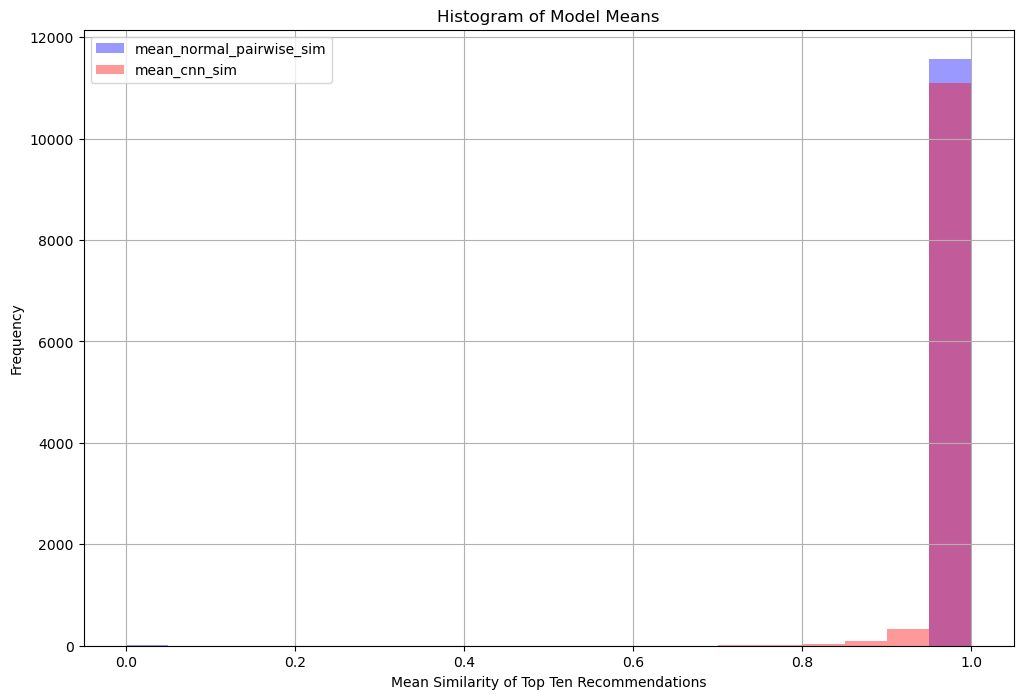

In [306]:
plt.figure()
model_means_df.loc[:, ["mean_normal_pairwise_sim", "mean_cnn_sim"]].plot(
    kind="hist",
    alpha=0.4,
    bins=20,
    title="Histogram of Model Means",
    grid=True,
    figsize=(12, 8),
    color=["blue", "red"],
)
plt.xlabel("Mean Similarity of Top Ten Recommendations")
plt.show()

[Back to Table of Contents](#toc)

## 9. Creating Recommendation Playlist <a class="anchor" id="9"></a>

In the final step, the Spotify API is queried to generate a playlist that contains the original track along with the top five matches in terms of similarity. It should be noted that to get this to work, a flask app was originally designed to allow for authentication of the scopes required for writing a playlist into the user's account. This code is used only once to generate those permissions and is presented below. However, it is commented out for the sake of brevity. Once the playlist is created using the parameters, the track IDs are passed in to populate the playlist which the user then has the ability to listen to from their personal Spotify account. It is also worth noting here, that due to difficulties in setting up the authorization code flow required for this step, ChatGPT was consulted in order to sketch out the original idea for how this process would work. Additionally, the video entitled ["Spotify OAuth: Automating Discover Weekly Playlist - Full Tutorial"](https://www.youtube.com/watch?v=mBycigbJQzA) by the YouTuber Synsation (Github: [katiagilligan888](https://github.com/katiagilligan888/Spotify-Discover-Weekly) was also used to help setup the authentication process.

### 9.1 Flask App for Authorization <a class="anchor" id="9_1"></a>

In [307]:
## THIS CODE WORKS -- However, I don't want to use a self-contained Flask app as it interrupts my flow
## This may be altered in the future to allow for real time use of the app for demonstration purposes.
# app = Flask(__name__)

# sp_oauth = SpotifyOAuth(
#     client_id=CLIENT_ID,
#     client_secret=CLIENT_SECRET,
#     redirect_uri=REDIRECT_URI,
#     scope=SCOPE,
#     cache_path=".cache",
# )


# @app.route("/")
# def index():
#     return "Hello, this is a Flask app!"


# @app.route("/login")
# def login():
#     auth_url = sp_oauth.get_authorize_url()
#     return redirect(auth_url)


# @app.route("/callback")
# def callback():
#     code = request.args["code"]
#     token_info = sp_oauth.get_access_token(code)
#     access_token = token_info["access_token"]

#     sp = spotipy.Spotify(auth=access_token)

#     username = sp.me()["id"]
#     playlist_name = "My Blank Playlist"

#     playlist = sp.user_playlist_create(user=username, name=playlist_name, public=False)

#     return f"Playlist '{playlist_name}' created by user '{username}'"


# if __name__ == "__main__":
#     app.run(port=5000)

[Back to Table of Contents](#toc)

### 9.2 Playlist Generator <a class="anchor" id="9_2"></a>

In [199]:
# Initialize SpotifyOAuth
sp_oauth = SpotifyOAuth(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    redirect_uri=REDIRECT_URI,
    scope=SCOPE,
    cache_path=".cache",
    show_dialog=False,
)


def main(normal_recommendations: List, cnn_recommendations: List):
    # Get cached token or start authorization process
    access_token_info = sp_oauth.get_cached_token()
    if access_token_info:
        access_token = access_token_info["access_token"]
    else:
        print("Authorization required. Visit the following URL to authorize:")
        auth_url = sp_oauth.get_authorize_url()
        print(auth_url)
        return

    # Initialize spotipy with access token
    sp = spotipy.Spotify(auth=access_token)

    # Replace 'Your Username' with your Spotify username
    username = USERNAME
    for track_recommendation in normal_recommendations:
        playlist_name = (
            f"Pairwise Recommendation Playlist for Track {track_recommendation[0]}"
        )
        playlist_description = f"These are the top 10 pairwise matches for track {track_recommendation[0]} by cosine similarity in descending order."

        try:
            # Create a blank playlist
            playlist = sp.user_playlist_create(
                user=username,
                name=playlist_name,
                description=playlist_description,
                public=False,
            )
            print(f"Pairwise Playlist '{playlist_name}' was created")
        except spotipy.SpotifyException as e:
            print(f"An error occurred: {e}")

        # List of track IDs (URIs) to add to the playlist
        prefix = "spotify:track:"
        track_uris = list(prefix + x for x in track_recommendation)

        # Add tracks to the playlist
        sp.user_playlist_add_tracks(
            user=username, playlist_id=playlist["id"], tracks=track_uris
        )
    for track_recommendation in cnn_recommendations:
        playlist_name = (
            f"CNN Recommendation Playlist for Track {track_recommendation[0]}"
        )
        playlist_description = f"These are the top 10 CNN matches for track {track_recommendation[0]} by cosine similarity in descending order."

        try:
            # Create a blank playlist
            playlist = sp.user_playlist_create(
                user=username,
                name=playlist_name,
                description=playlist_description,
                public=False,
            )
            print(f"CNN Playlist '{playlist_name}' was created")
        except spotipy.SpotifyException as e:
            print(f"An error occurred: {e}")

        # List of track IDs (URIs) to add to the playlist
        prefix = "spotify:track:"
        track_uris = list(prefix + x for x in track_recommendation)

        # Add tracks to the playlist
        sp.user_playlist_add_tracks(
            user=username, playlist_id=playlist["id"], tracks=track_uris
        )


if __name__ == "__main__":
    main(normal_recommendations, cnn_recommendations)

Pairwise Playlist 'Pairwise Recommendation Playlist for Track 0Orkpepcdaq5GvnLh1Wb6p' was created
Pairwise Playlist 'Pairwise Recommendation Playlist for Track 3jOLdUMjt9nXjnLmbgnKBf' was created
Pairwise Playlist 'Pairwise Recommendation Playlist for Track 7sqdeBH06y0C3lHWVkK5HK' was created
Pairwise Playlist 'Pairwise Recommendation Playlist for Track 2QbR9yeeX7XHznRZwsyh3F' was created
Pairwise Playlist 'Pairwise Recommendation Playlist for Track 4dYUOfmWna6DFccnz732n8' was created
Pairwise Playlist 'Pairwise Recommendation Playlist for Track 3BUFs1YNRBoGgYNrK9hQov' was created
Pairwise Playlist 'Pairwise Recommendation Playlist for Track 1DSHVZBpsWVAmYOIXrTBVT' was created
Pairwise Playlist 'Pairwise Recommendation Playlist for Track 1IAMR2fZdD3ddqttxj9naT' was created
Pairwise Playlist 'Pairwise Recommendation Playlist for Track 7lb6AOilTFuvgokDoBEml7' was created
Pairwise Playlist 'Pairwise Recommendation Playlist for Track 3qjXFLKMp4zfMmugEGPaBx' was created
CNN Playlist 'CNN Re

The output playlist then looks like the screenshot below:
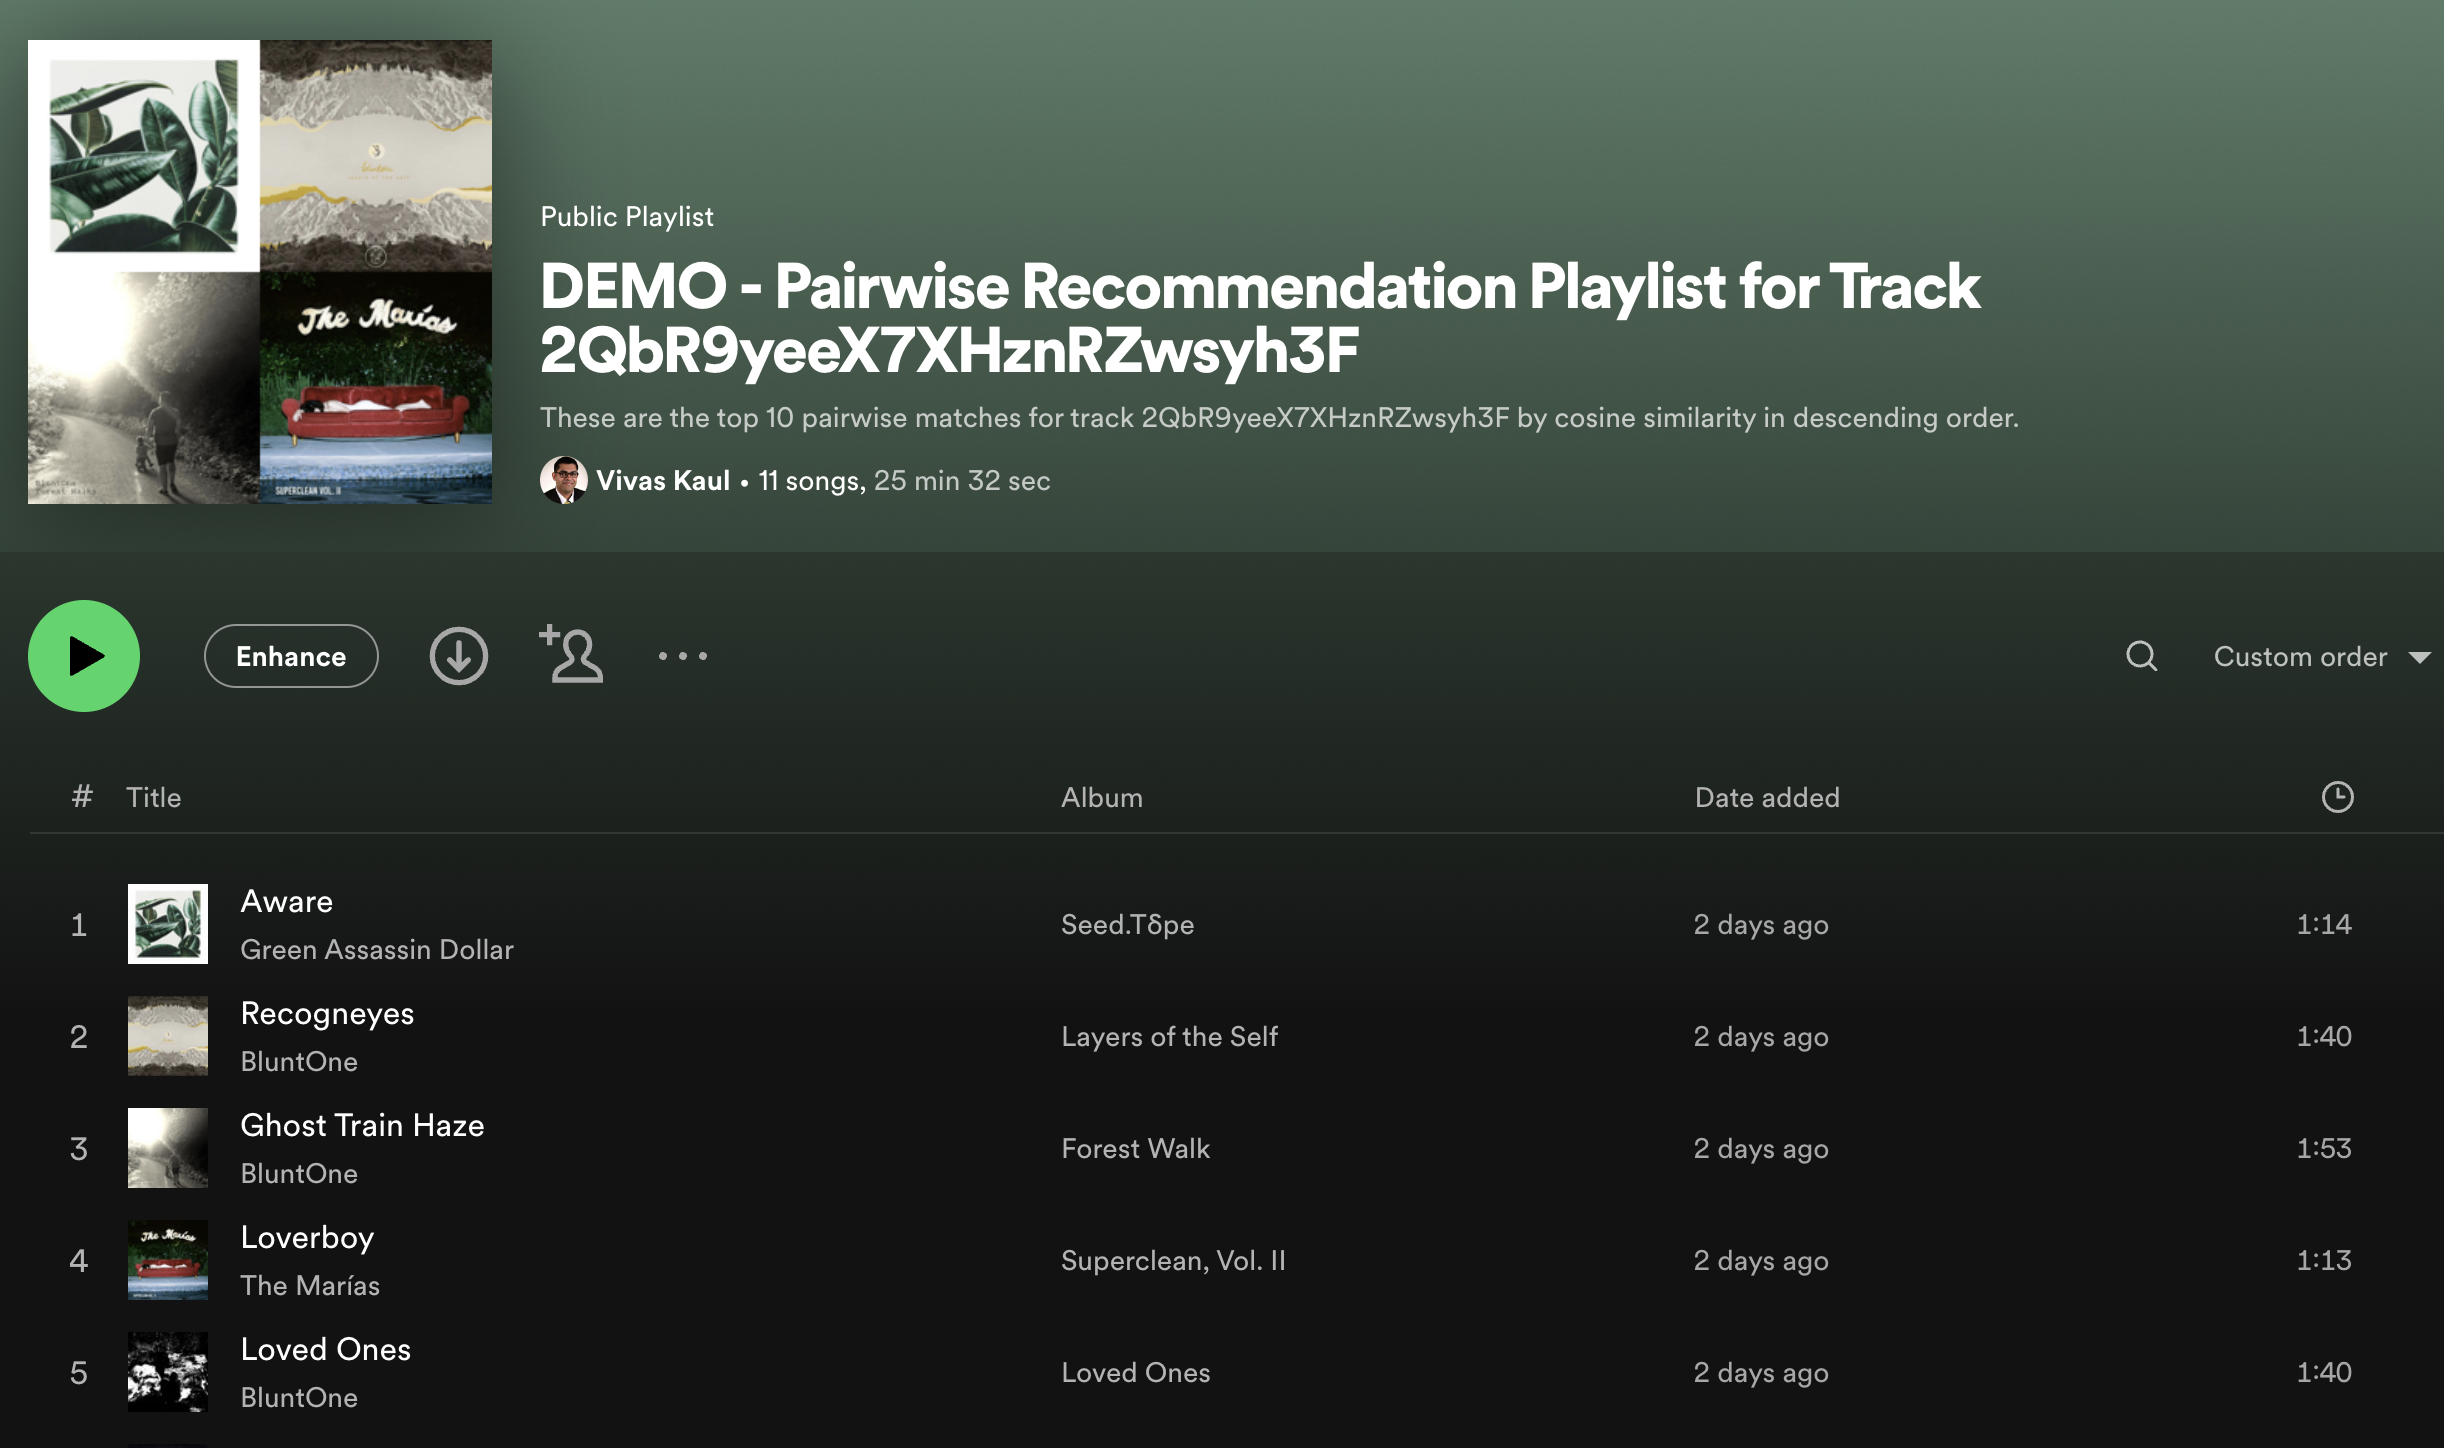

[Back to Table of Contents](#toc)

## 10. Conclusion <a class="anchor" id="10"></a>

In conclusion, Sprint 2 saw the development of several key strides forward in the creation of a model. First it saw the acquisition and encoding of a training set of more than 11,000 mp3s. This data was then vectorized into a 498 dimension vector and used to produce a pairwise similarity. Finally, the results of similarity calculation were then used to produce a playlist of songs and provided to the user for their consideration. In terms of future plans, for Sprint 3 the focus will be on creating a more robust model using a convolutional neural network (CNN) and also further defining the success metric for the recommendations that are provided. One possibility would be to compare the results generated with the recommendation engine from Spotify itself. Another possibility might be to serve this code to some of the other students from within the cohort and get their feedback as to the recommendations provided by the engine.

[Back to Table of Contents](#toc)